In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d
import glob
import tqdm
from labellines import *
import seaborn as sns
from astropy.io import fits
from scipy.stats import linregress
import math

divergent=LinearSegmentedColormap.from_list('divergent', (
    # Edit this gradient at https://eltos.github.io/gradient/#0D7D87-99C6CC-FBFBFB-EE9093-C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.250, (0.600, 0.776, 0.800)),
    (0.500, (0.984, 0.984, 0.984)),
    (0.750, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))

my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:0D7D87-20.8:99C6CC-40:B6B66B-60:F47A00-80:EE9093-100:C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.208, (0.600, 0.776, 0.800)),
    (0.400, (0.714, 0.714, 0.420)),
    (0.600, (0.957, 0.478, 0.000)),
    (0.800, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))
#Formatting for plots
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')
# DiscModel is in a different file
from src.DiscModel import DiscGalaxy
N = 1000000 # number of stars in the disc
a = 1 # a is the scale length of the disc in kpc
D = DiscGalaxy(N=N,a=a)

rmax = 212.
nbins = 64
mmax = 10
nmax = 10

noise = 0.5
save_dir = "/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper"

"""Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes."""

'Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes.'

In [2]:
def galaxy_morphology(file):
    
    def FindInc2(eta, A, B, C, D):
        
        if eta>0.5:
            inc=90
        else:
            # 1) Safe inverse argument (A can be negative)
            x = np.clip((eta - D) / A, -1.0, 1.0)

            # 2) Two branches from cos symmetry, all in radians
            a = np.arccos(x)                # in [0, pi]
            i1 = (a - C) / B
            i2 = (-a - C) / B

            # 3) Convert candidates to degrees
            cand = np.rad2deg(np.array([i1, i2]))

            # 4) Reduce by the period in degrees: P = 2π/|B| (then to degrees)
            P = np.rad2deg(2*np.pi / abs(B))
            cand = cand % P                 # map into one period

            # 5) Fold into [0, 180], then reflect >90 across 90 to get [0, 90]
            cand = np.where(cand > 180.0, cand - 180.0, cand)
            cand = np.where(cand > 90.0, 180.0 - cand, cand)

            # 6) Pick the candidate that best reproduces eta (keeps you on the line)
            def model(i_deg):
                return A*np.cos(B*np.deg2rad(i_deg) + C) + D

            errs = np.abs(model(cand) - eta)
            inc=float(cand[np.argmin(errs)])
        return inc
    
    
    with fits.open(file) as hdulist:
        image_data = hdulist[1].data
        
    galaxy_name = file.split("-")[0]
    h, w = image_data.shape

    gray=image_data.copy() 
    rmaxx = h // 2
    rmaxy = w // 2
   
    radius=h//4
    cx, cy = w//2, h//2
    y, x = np.indices((h,w))
    mask = (x - cx)**2 + (y - cy)**2 <= radius**2
    gray = np.where(mask, gray, 0.0)
    x_edges = np.linspace(-rmaxy, rmaxy, w + 1)
    y_edges = np.linspace(-rmaxx, rmaxx, h + 1)
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
    

    R = np.sqrt(X2**2 + Y2**2).ravel()
    I = image_data.ravel()

    # Filter for positive intensities and R <= 80
    valid = (I > 0) & (R <= 80)
    R_valid = R[valid]
    logI_valid = np.log(I[valid])
   
    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(R_valid, logI_valid)
    scale_length = -1 / slope
    if scale_length < 0:
        scale_length = 50
    if scale_length > 100:
        scale_length = 30
    
    a=scale_length*1.5


    x_edges = np.asarray(x_edges).ravel()
    y_edges = np.asarray(y_edges).ravel()

    if x_edges.size < 2 or y_edges.size < 2:
        raise ValueError("Need at least two edges along each axis.")

    # If reversed (common for image-style Y axes), flip them:
    if x_edges[0] > x_edges[-1]:
        x_edges = x_edges[::-1]
    if y_edges[0] > y_edges[-1]:
        y_edges = y_edges[::-1]

    # If they’re not strictly increasing (duplicates), uniquify & sort:
    x_edges = np.unique(x_edges)
    y_edges = np.unique(y_edges)
    D = DiscGalaxy(N=N,a=a,M=np.sum(gray))   
    D.img       = gray.T   
    D.x_edges   = x_edges
    D.y_edges   = y_edges
    D.x_centers = x_centers
    D.y_centers = y_centers

    mmax, nmax = 8, 10
    E1 = D.make_expansion(mmax, nmax, a*1.5, noisy=False)
    
    c1 = E1.coscoefs; s1 = E1.sincoefs
   
    num = np.sqrt(sum((c1[2, n]**2 + s1[2, n]**2) for n in range(nmax)))
    den     = sum(abs(c1[0,n])            for n in range(nmax))

    eta_bt     = num/den
    A=-0.289256915274715
    B=-1.7006080841260558
    C=6.54207283791996
    D=0.34764087089364026
    
    A=-0.30845928737374684
    B=-1.6564105427131928
    C=6.430938401182824

    D=0.3145522357466893
    
    A=0.27262716014051763 
    B=-1.8397445743459468 
    C=3.3452301250356076 
    D=0.27926458537922233
    inc_bt=FindInc2(eta_bt,A,B,C,D)

    PA=90+(np.arctan2(s1[2,0],c1[2,0])* 180/np.pi)/2

    return inc_bt, PA, galaxy_name
    
Name=[]
Inc=[]
PA=[]
fits_files = glob.glob('gfits3/*.fits.fz')

for idx, file in enumerate(fits_files):
    A=galaxy_morphology(file)
    Name.append(A[2])
    Inc.append(A[0])
    PA.append(A[1]) 
    print(f"Processed {A[2]}, ID {idx}: Inc={A[0]:.2f}, PA={A[1]:.2f}")

Processed gfits3/NGC5289, ID 0: Inc=32.36, PA=99.43
Processed gfits3/NGC6186, ID 1: Inc=40.02, PA=58.08
Processed gfits3/NGC3310, ID 2: Inc=25.33, PA=4.16
Processed gfits3/NGC2893, ID 3: Inc=25.02, PA=158.45
Processed gfits3/NGC2776, ID 4: Inc=20.30, PA=127.42
Processed gfits3/NGC4203, ID 5: Inc=26.09, PA=8.14
Processed gfits3/NGC5676, ID 6: Inc=45.08, PA=42.79
Processed gfits3/NGC4369, ID 7: Inc=43.49, PA=147.64
Processed gfits3/NGC4100, ID 8: Inc=66.17, PA=163.58
Processed gfits3/NGC5112, ID 9: Inc=59.57, PA=127.71
Processed gfits3/NGC3726, ID 10: Inc=43.14, PA=15.69
Processed gfits3/NGC4359, ID 11: Inc=78.86, PA=109.70
Processed gfits3/NGC3556, ID 12: Inc=90.00, PA=82.50
Processed gfits3/NGC6217, ID 13: Inc=27.35, PA=151.32
Processed gfits3/NGC3403, ID 14: Inc=65.13, PA=74.64
Processed gfits3/NGC6140, ID 15: Inc=48.58, PA=73.73
Processed gfits3/NGC3118, ID 16: Inc=64.44, PA=38.39
Processed gfits3/NGC4051, ID 17: Inc=48.51, PA=133.96
Processed gfits3/NGC2985, ID 18: Inc=30.84, PA=172

KeyboardInterrupt: 

Processed gfits3/NGC3319: Inc=62.32, PA=-35.82, eta=0.34


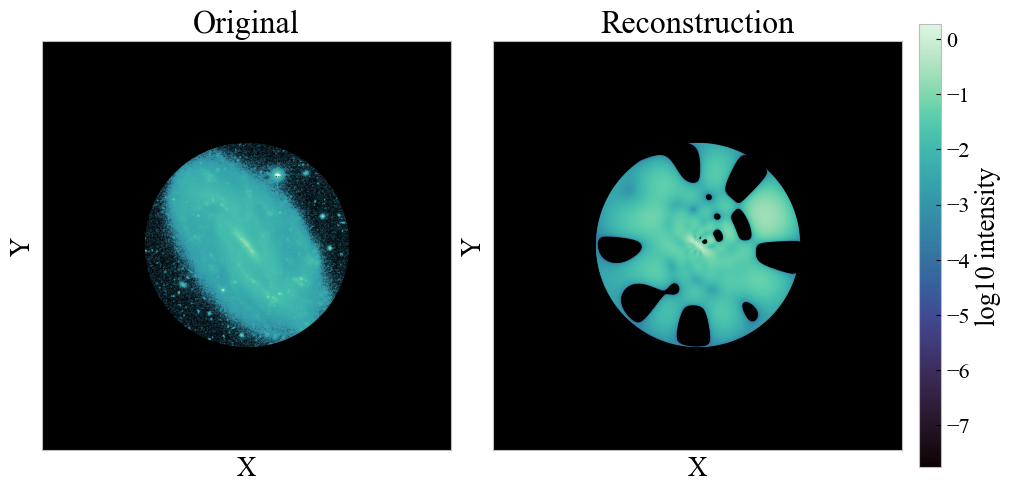

KeyboardInterrupt: 

<Figure size 900x600 with 0 Axes>

In [3]:
import os
from matplotlib.backends.backend_pdf import PdfPages

def galaxy_morphology(file):
    
    def FindInc2(eta, A, B, C, D):
        
        if eta>0.5:
            inc=90
        else:
            # 1) Safe inverse argument (A can be negative)
            x = np.clip((eta - D) / A, -1.0, 1.0)

            # 2) Two branches from cos symmetry, all in radians
            a = np.arccos(x)                # in [0, pi]
            i1 = (a - C) / B
            i2 = (-a - C) / B

            # 3) Convert candidates to degrees
            cand = np.rad2deg(np.array([i1, i2]))

            # 4) Reduce by the period in degrees: P = 2π/|B| (then to degrees)
            P = np.rad2deg(2*np.pi / abs(B))
            cand = cand % P                 # map into one period

            # 5) Fold into [0, 180], then reflect >90 across 90 to get [0, 90]
            cand = np.where(cand > 180.0, cand - 180.0, cand)
            cand = np.where(cand > 90.0, 180.0 - cand, cand)

            # 6) Pick the candidate that best reproduces eta (keeps you on the line)
            def model(i_deg):
                return A*np.cos(B*np.deg2rad(i_deg) + C) + D

            errs = np.abs(model(cand) - eta)
            inc=float(cand[np.argmin(errs)])
        return inc
    
    
    with fits.open(file) as hdulist:
        image_data = hdulist[1].data
        
    galaxy_name = file.split("-")[0]
    h, w = image_data.shape

    gray=image_data.copy() 
    rmaxx = h // 2
    rmaxy = w // 2
   
    radius=h//4
    cx, cy = w//2, h//2
    y, x = np.indices((h,w))
    mask = (x - cx)**2 + (y - cy)**2 <= radius**2
    gray = np.where(mask, gray, 0.0)
    x_edges = np.linspace(-rmaxy, rmaxy, w + 1)
    y_edges = np.linspace(-rmaxx, rmaxx, h + 1)
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
    

    R = np.sqrt(X2**2 + Y2**2).ravel()
    I = image_data.ravel()

    # Filter for positive intensities and R <= 80
    valid = (I > 0) & (R <= 80)
    R_valid = R[valid]
    logI_valid = np.log(I[valid])
   
    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(R_valid, logI_valid)
    scale_length = -1 / slope
    if scale_length < 0:
        scale_length = 50
    if scale_length > 100:
        scale_length = 30
    
    a=scale_length*1.5


    x_edges = np.asarray(x_edges).ravel()
    y_edges = np.asarray(y_edges).ravel()

    if x_edges.size < 2 or y_edges.size < 2:
        raise ValueError("Need at least two edges along each axis.")

    # If reversed (common for image-style Y axes), flip them:
    if x_edges[0] > x_edges[-1]:
        x_edges = x_edges[::-1]
    if y_edges[0] > y_edges[-1]:
        y_edges = y_edges[::-1]

    # If they’re not strictly increasing (duplicates), uniquify & sort:
    x_edges = np.unique(x_edges)
    y_edges = np.unique(y_edges)
    D = DiscGalaxy(N=N,a=a,M=np.sum(gray))   
    D.img       = gray
    D.x_edges   = x_edges
    D.y_edges   = y_edges
    D.x_centers = x_centers
    D.y_centers = y_centers

    mmax, nmax = 8, 10
    E1 = D.make_expansion(mmax, nmax, a*1.5, noisy=False)
    
    c1 = E1.coscoefs; s1 = E1.sincoefs
   
    num = np.sqrt(sum((c1[2, n]**2 + s1[2, n]**2) for n in range(nmax)))
    den     = sum(abs(c1[0,n])            for n in range(nmax))

    eta_bt     = num/den

    
    A=-0.30845928737374684
    B=-1.6564105427131928
    C=6.430938401182824

    D=0.3145522357466893
    inc_bt=FindInc2(eta_bt,A,B,C,D)

    PA=(np.arctan2(s1[2,0],c1[2,0])* 180/np.pi)/2

    return  inc_bt, PA, galaxy_name,eta_bt
eta=[]
Name=[]
Inc=[]
PA=[]
fits_files = glob.glob('gfits3/*.fits.fz')



file=fits_files[33]

A=galaxy_morphology(file)
Name.append(A[2])
Inc.append(A[0])
PA.append(A[1])
eta.append(A[3])

print(f"Processed {A[2]}: Inc={A[0]:.2f}, PA={A[1]:.2f}, eta={A[3]:.2f}")

with fits.open(file) as hdulist:
        image_data = hdulist[1].data
        
galaxy_name = file.split("-")[0]
h, w = image_data.shape

gray=image_data.copy() 
rmaxx = h // 2
rmaxy = w // 2

radius=h//4
cx, cy = w//2, h//2
y, x = np.indices((h,w))
mask = (x - cx)**2 + (y - cy)**2 <= radius**2
gray = np.where(mask, gray, 0.0)
x_edges = np.linspace(-rmaxy, rmaxy, w + 1)
y_edges = np.linspace(-rmaxx, rmaxx, h + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')

R = np.sqrt(X2**2 + Y2**2).ravel()
I = image_data.ravel()

# Filter for positive intensities and R <= 80
valid = (I > 0) & (R <= 80)
R_valid = R[valid]
logI_valid = np.log(I[valid])

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(R_valid, logI_valid)
scale_length = -1 / slope
if scale_length < 0:
    scale_length = 50
if scale_length > 100:
    scale_length = 30

a=scale_length*1.5


x_edges = np.asarray(x_edges).ravel()
y_edges = np.asarray(y_edges).ravel()

if x_edges.size < 2 or y_edges.size < 2:
    raise ValueError("Need at least two edges along each axis.")

# If reversed (common for image-style Y axes), flip them:
if x_edges[0] > x_edges[-1]:
    x_edges = x_edges[::-1]
if y_edges[0] > y_edges[-1]:
    y_edges = y_edges[::-1]

# If they’re not strictly increasing (duplicates), uniquify & sort:
x_edges = np.unique(x_edges)
y_edges = np.unique(y_edges)
D = DiscGalaxy(N=N,a=a,M=np.sum(gray))   
D.img       = gray  
D.x_edges   = x_edges
D.y_edges   = y_edges
D.x_centers = x_centers
D.y_centers = y_centers

mmax, nmax = 8, 10
E1 = D.make_expansion(mmax, nmax, a*1.5, noisy=False)

img_orig = D.img.copy()



# --- Laguerre expansion & reconstruction on the same grid ---
E1 = D.make_expansion(mmax, nmax, a, noisy=False)
E1.laguerre_reconstruction(D.r, D.p)   # produces E1.reconstruction on a point set

# Map reconstruction back to the image grid via histogramming
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
x_flat = X2.ravel()
y_flat = Y2.ravel()
w_flat = E1.reconstruction.ravel()

recon_img, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges],
    weights=w_flat
)
counts, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges]
)

# avoid divide-by-zero; normalize total flux to the original image
recon_img = recon_img / np.maximum(counts, 1)
# match total intensity
total_recon = np.sum(recon_img)
if total_recon > 0:
    recon_img *= np.sum(img_orig) / total_recon

recon_img = recon_img.T  # to match imshow orientation


# --- Plot side by side ---
cmap = sns.color_palette("mako", as_cmap=True)
mask = (x - cx)**2 + (y - cy)**2 <= radius**2
recon_img = np.where(mask*1.2, recon_img, 0.0)
orig_log = np.log10(np.where(img_orig > 0, img_orig, np.nan))
recon_log = np.log10(np.where(recon_img > 0, recon_img, np.nan))
x_edges = np.linspace(-rmaxx, rmaxx, nbins + 1)
y_edges = np.linspace(-rmaxy, rmaxy, nbins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
N=1000000
D = DiscGalaxy(N=N, a=a*1.5, M=np.sum(gray))
D.rotate_disc(62.32, 0, 90+35.82)   # inc=50, PA=45
D.generate_image(rmax=rmaxx, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()
origdisc_log = np.log10(np.where(img_orig > 0, img_orig, np.nan))
fig1, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/fourierexp3319.pdf') as pp:
    for ax, im, title in zip(axes, [orig_log, recon_log], ["Original", "Reconstruction"]):
        h = ax.imshow(im, extent=extent, cmap=cmap, origin="lower")
        ax.set_title(title)
        ax.set(facecolor="black")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlabel("X"); ax.set_ylabel("Y")

    cbar = fig1.colorbar(h, ax=axes, shrink=0.9, pad=0.02)
    cbar.set_label("log10 intensity")

    # Save into the PDF
    pp.savefig(fig1)

plt.show()

incl_list = np.linspace(0, 85, 30)   # inclinations to sample
PA_list   = np.linspace(0, 180, 20)    # PAs to sample
colorindx = np.linspace(0, 1, len(incl_list) + 1)  # FIX: len(incl_list)+1
N = 1000000
a = 6                    # reconstruction scale as requested
rmax = 212/2
h=212
w=212
nbins = 212
noise = 0.0
mmax, nmax = 10, 10
incs = [0, 30, 45, 60, 90]
PAs= [0, 30, 45, 60, 90]  # Position angles in degrees

plt.figure(figsize=(9, 6))
eta_avg_list = []
for i, inc in enumerate(incl_list):
    etas, eta_cos_list, eta_sin_list = [], [], []
    for PA in PA_list:
        D = DiscGalaxy(N=N, a=a, M=np.sum(gray))
        D.rotate_disc(inc, 0, PA)
        D.generate_image(rmax=min(rmaxx, rmaxy), nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, a)

        coscoefs = E.coscoefs
        sincoefs = E.sincoefs

        denom   = sum(abs(coscoefs[0, n]) for n in range(nmax)) or np.nan
        num     = np.sqrt(sum((coscoefs[2, n]**2 + sincoefs[2, n]**2) for n in range(nmax)))
        num_cos = np.sign(coscoefs[2, 0]) * sum(abs(coscoefs[2, n]) for n in range(nmax))
        num_sin = np.sign(sincoefs[2, 0]) * sum(abs(sincoefs[2, n]) for n in range(nmax))

        eta     = num / denom
        eta_cos = num_cos / denom
        eta_sin = num_sin / denom
        eta_cos=90-(np.arctan2(sincoefs[2,0],coscoefs[2,0])* 180/np.pi)/2

        etas.append(eta)
        eta_cos_list.append(eta_cos)
        eta_sin_list.append(eta_sin)

    eta_avg = np.nanmean(etas)
    eta_avg_list.append(eta_avg)
    
    
def cos_function(x_deg, A, B, C, D):
    return A * np.cos(B * np.radians(x_deg) + C) + D


inc_fit = np.linspace(0.0, 90.0, 500)
A=-0.30845928737374684
B=-1.6564105427131928
C=6.430938401182824

D=0.3145522357466893

eta_fit = cos_function(inc_fit, A, B, C, D)

plt.figure(figsize=(8, 5))
plt.plot(inc_fit, eta_fit, label=rf'Fit {A:.1f}$\cos$({B:.1f}$x$ + {C:.1f}) + {D:.1f}', linewidth=2, color=my_gradient(0.95))
plt.scatter(incl_list, eta_avg_list, label=r'Model $\eta$ and Inclination', color=my_gradient(0))
plt.scatter(Inc[0], eta[0], label='Blind-test from image', color='red', s=100, edgecolor='black', zorder=5)

plt.xlabel(r'Inclination (deg)')
plt.ylabel(r'$\eta$')
plt.title(r'Cosine Fit to $\eta$ vs Inclination')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

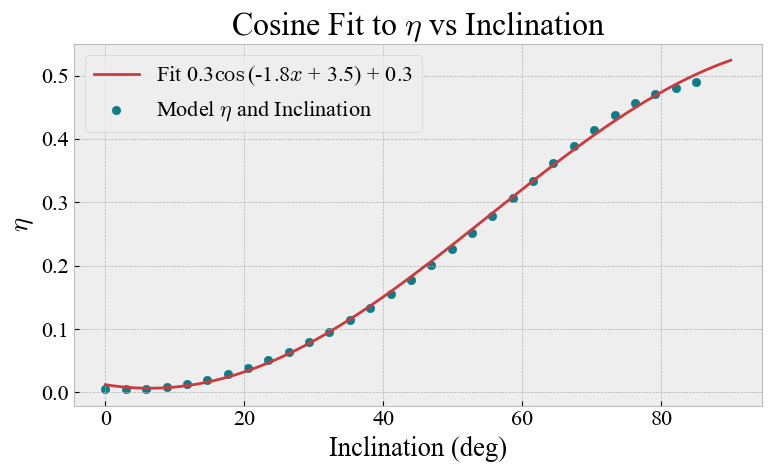

In [ ]:
def cos_function(x_deg, A, B, C, D):
    return A * np.cos(B * np.radians(x_deg) + C) + D


inc_fit = np.linspace(0.0, 90.0, 500)
A=0.27262716014051763
B=-1.8397445743459468
C=3.3452301250356076
D=0.27926458537922233

eta_fit = cos_function(inc_fit, A, B, C, D)
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/InclFit.pdf') as pp:
    plt.figure(figsize=(8, 5))
    plt.plot(inc_fit, eta_fit, label=rf'Fit {A:.1f}$\cos$({B:.1f}$x$ + {3.5:.1f}) + {D:.1f}', linewidth=2, color=my_gradient(0.95))
    plt.scatter(incl_list, eta_avg_list, label=r'Model $\eta$ and Inclination', color=my_gradient(0))
    #plt.scatter(62.32,0.34, label='Fit for NGC3319', color='red', s=100, edgecolor='black', zorder=5)

    plt.xlabel(r'Inclination (deg)')
    plt.ylabel(r'$\eta$')
    plt.title(r'Cosine Fit to $\eta$ vs Inclination')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pp.savefig()
plt.show()

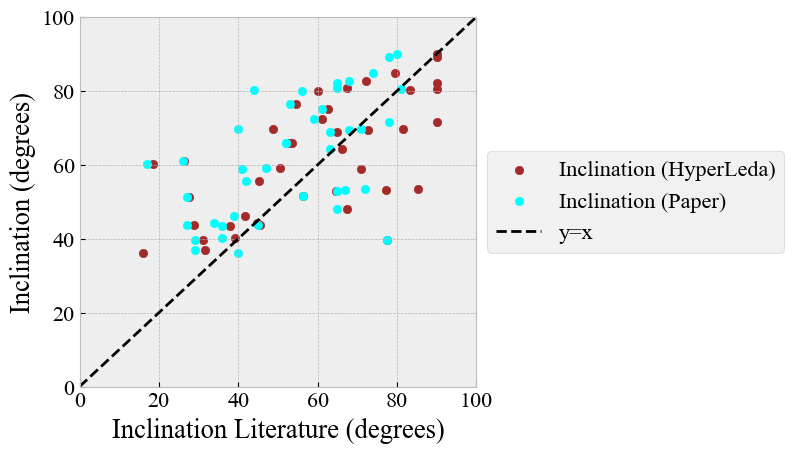

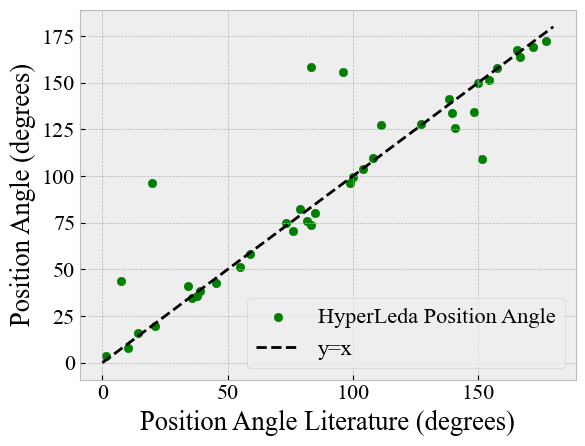

In [21]:
incl = [
    21.54, 38.55, 31.16, 39.33, 73.36, 76.26, 32.85, 53.95, 28.27, 109.75,
    31.55, 27.24, 36.88, 61.25, 73.60, 23.08, 109.75, 57.04, 36.95, 73.03,
    92.74, 109.75, 28.86, 79.60, 54.04, 39.20, 79.38, 37.78, 41.53, 81.25,
    32.77, 109.75, 37.98, 52.61, 109.75, 54.75, 60.89, 45.16, 25.94, 57.67,
    62.91
]
incl_a200 = [
    17.11, 24.35, 41.26, 33.68, 60.17, 69.92, 26.52, 52.17, 6.95, 90.36,
    41.92, 37.20, 45.08, 55.28, 59.07, 27.92, 98.86, 63.03, 26.89, 83.35,
    82.63, 91.20, 25.49, 75.96, 48.68, 32.75, 63.31, 31.43, 46.88, 65.08,
    56.23, 109.75, 43.69, 49.13, 109.75, 63.21, 53.01, 53.64, 39.06, 55.26,
    48.32
]

values = [
    19.82, 29.11, 24.70, 30.70, 66.50, 64.39, 26.50, 43.07, 25.02, 62.29,
    31.18, 25.01, 32.72, 46.67, 65.04, 24.50, 90.00, 43.31, 29.81, 48.75,
    66.02, 90.00, 25.80, 77.28, 43.66, 30.66, 57.64, 29.65, 36.49, 59.70,
    32.27, 78.71, 32.60, 45.27, 90.00, 51.15, 48.81, 40.13, 27.10, 53.52,
    51.70
]

paper_incl = [
    65, 42, 36, 36, 71, 78, 29, 59, 40, 61,
    56.3, 77.6, 27, 26, 68, 29, 65, 47, 27, 40,
    74, 81, 65, 53, 17, 39, 63, 45, 65, 52,
    72, 78, 67, 63, 80, 68, 44, 41, 34, 52,
    56
]

hyperleda_incl = [
    67.4, 45.2, 39.1, 37.9, 81.6, 90, 31.2, 61.1, 16.1, 62.7,
    56.3, 77.6, 27.7, 26.3, 72.1, 31.7, 67.5, 50.5, 28.9, 48.7,
    79.5, 90, 90, 54.5, 18.6, 41.7, 64.8, 45.4, 64.6, 53.6,
    85.3, 90, 77.2, 66.2, 90, 72.7, 83.3, 71, 44.8, 52.7,
    60.1
]
Inc = [
    47.99,
    55.68,
    40.11,
    43.52,
    69.75,
    71.63,
    39.66,
    72.34,
    36.24,
    75.17,
    51.44,
    39.76,
    51.26,
    61.06,
    82.62,
    36.84,
    80.87,
    59.06,
    43.79,
    69.76,
    84.95,
    80.53,
    82.16,
    76.38,
    60.14,
    46.06,
    68.86,
    43.83,
    52.99,
    65.79,
    53.45,
    89.17,
    53.14,
    64.17,
    89.87,
    69.45,
    80.37,
    58.77,
    44.35,
    65.77,
    79.99
]

pa = [
    127.42, 96.1, 158.45, 172.61, 103.76, 38.39, 109.37, 43.62, 4.16, 35.9,
    141.5, 51.35, 19.92, 70.78, 74.64, 125.64, 82.5, 15.69, 155.55, 133.96,
    163.58, 167.31, 8.14, 109.7, 147.64, 80.02, 134.47, 34.94, 169.05, 127.71,
    99.43, 149.76, 41, 42.79, 75.95, 3.71, 73.73, 58.08, 151.32, 157.8,
    96.29
]

hyperleda_pa = [
    111.3, 20, 83.4, 177, 104.1, 39, 151.7, 7.5, None, 37.7,
    138.5, 55, 21.2, 75.9, 73.4, 140.9, 79, 14.2, 95.9, 139.4,
    166.8, 165.6, 10.2, 107.9, None, 84.9, 148.3, 35.7, 171.8, 127,
    100, 150, 34, 45.5, 81.7, 1.5, 83.3, 58.9, 154.5, 157.4,
    98.8
]

sqrt_sum_a200 = [
    30.22, 25.75, 16.38, 20.36, 0.79, 6.15, 24.76, 8.80, 34.14, 82.19,
    14.98, 18.33, 12.52, 7.57, 1.35, 23.95, 52.79, 3.86, 24.78, 84.69,
    79.31, 72.17, 24.56, 84.81, 11.51, 19.67, 82.27, 16.22, 8.94, 4.65,
    5.35, 61.81, 10.67, 5.39, 66.22, 0.78, 7.57, 6.34, 13.36, 2.82,
    7.57
]

sqrt_sum_aa = [
    27.31, 17.29, 21.55, 16.47, 74.23, 77.21, 20.15, 3.72, 23.22, 77.99,
    15.50, 21.23, 12.91, 0.69, 77.03, 21.97, 66.22, 2.13, 17.83, 5.16,
    72.12, 52.62, 22.08, 64.77, 3.90, 16.33, 84.87, 16.73, 9.69, 81.09,
    13.63, 59.82, 13.16, 0.15, 66.22, 5.26, 1.58, 6.41, 19.09, 6.96,
    4.57
]
newcoeffs = [
    19.82,
    29.11,
    24.70,
    30.70,
    66.50,
    64.39,
    26.50,
    43.07,
    25.02,
    62.29,
    31.18,
    25.01,
    32.72,
    46.67,
    65.04,
    24.50,
    90.00,
    43.31,
    29.81,
    48.75,
    66.02,
    90.00,
    25.80,
    77.28,
    43.66,
    30.66,
    57.64,
    29.65,
    36.49,
    59.70,
    32.27,
    78.71,
    32.60,
    45.27,
    90.00,
    51.15,
    48.81,
    40.13,
    27.10,
    53.52,
    51.70
]

values2 = [
    20.30,
    29.30,
    25.02,
    30.84,
    66.68,
    64.44,
    26.77,
    42.91,
    25.33,
    62.24,
    31.31,
    25.33,
    32.80,
    46.46,
    65.13,
    24.83,
    90.00,
    43.14,
    29.97,
    48.51,
    66.17,
    90.00,
    26.09,
    78.86,
    43.49,
    30.80,
    57.46,
    29.82,
    36.46,
    59.57,
    32.36,
    80.63,
    32.69,
    45.08,
    90.00,
    50.91,
    48.58,
    40.02,
    27.35,
    53.29,
    51.46
]


x=np.linspace(0, 180, 100)
fig = plt.figure()
ax = plt.subplot(111)
""" plt.scatter(paper_incl, incl, label='Paper Inclination', color='blue')
plt.scatter(hyperleda_incl, incl, label='HyperLeda Inclination', color='orange')
plt.scatter(hyperleda_incl, incl_a200, label='Inclination a=200', color='red')
plt.scatter(paper_incl, incl_a200, label='Inclination( Paper)', color='purple')"""
plt.scatter(hyperleda_incl, Inc, label='Inclination (HyperLeda)', color='brown')
plt.scatter(paper_incl,Inc, label='Inclination (Paper)', color='cyan')
plt.plot(x, x, color='black', linestyle='--', label='y=x')
plt.xlabel('Inclination Literature (degrees)')
plt.ylabel('Inclination (degrees)')
plt.xlim(0, 100)
plt.ylim(0, 100)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.scatter(hyperleda_pa, pa, label='HyperLeda Position Angle', color='green')
plt.plot(x, x, color='black', linestyle='--', label='y=x')
plt.xlabel('Position Angle Literature (degrees)')
plt.ylabel('Position Angle (degrees)')
plt.legend()
plt.show()  

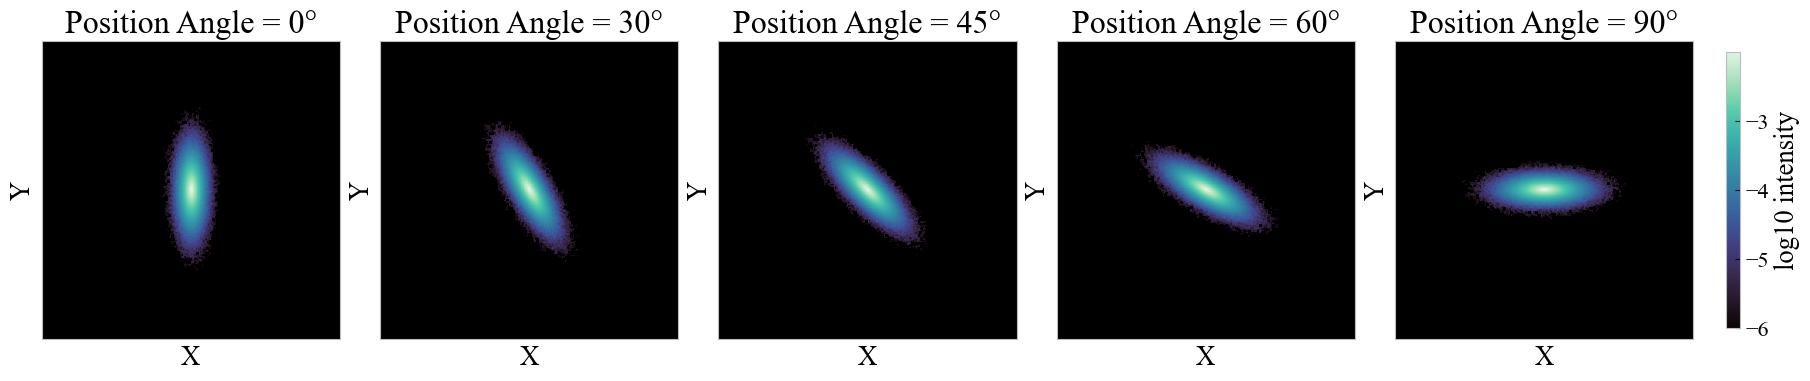

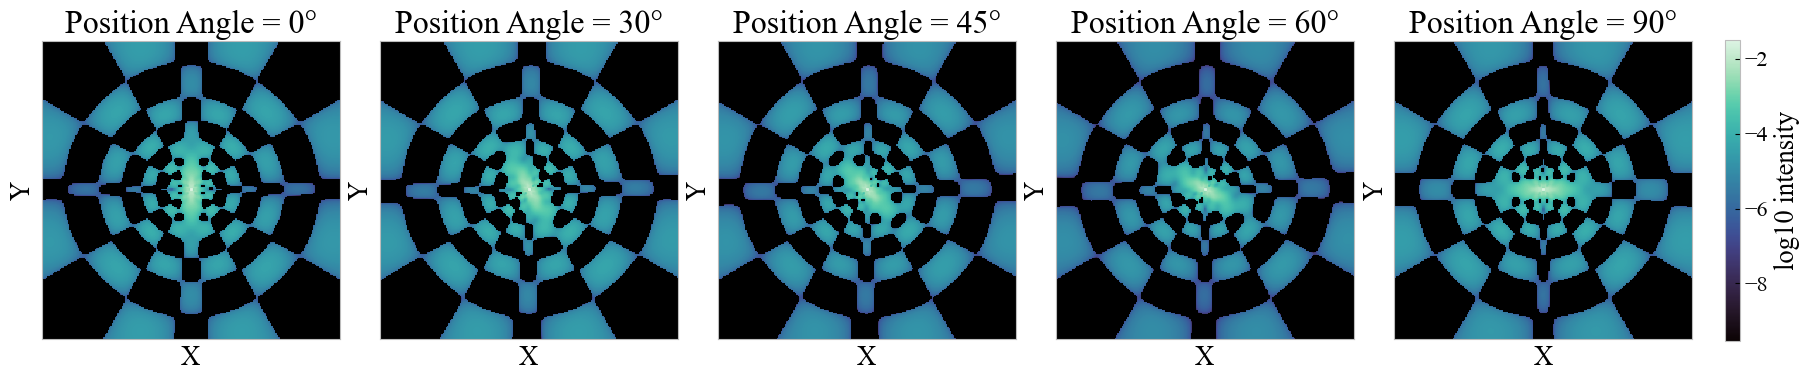

Amn (rows = n, columns = m):
[[114.   2.  12.   2.   2.   1.   1.]
 [  7.   1.   4.   2.   3.   0.   2.]
 [  0.   1.   1.   1.   3.   0.   1.]
 [  1.   1.   2.   0.   2.   1.   1.]
 [  0.   1.   2.   1.   1.   2.   2.]
 [  0.   1.   3.   2.   1.   2.   3.]
 [  0.   1.   2.   2.   1.   2.   4.]
 [  1.   1.   2.   2.   1.   2.   4.]]


In [ ]:
import seaborn as sns
N = 1000000
a = 6                    # reconstruction scale as requested
rmax = 212/2
nbins = 212
noise = 0.0
mmax, nmax = 10, 10
incs = [0, 30, 45, 60, 90]
PAs= [0, 30, 45, 60, 90]  # Position angles in degrees

# precompute grid edges/centers + extent
x_edges = np.linspace(-rmax, rmax, nbins + 1)
y_edges = np.linspace(-rmax, rmax, nbins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]

orig_imgs = []
recon_imgs = []

for PA in PAs:
    # --- simulate & get original image ---
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(70, 0, 90+PA)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    img_orig = D.img.copy()
    orig_imgs.append(img_orig)

    # --- Laguerre expansion & reconstruction on the same grid ---
    E1 = D.make_expansion(mmax, nmax, a, noisy=False)
    E1.laguerre_reconstruction(D.r, D.p)   # produces E1.reconstruction on a point set

    # Map reconstruction back to the image grid via histogramming
    X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
    x_flat = X2.ravel()
    y_flat = Y2.ravel()
    w_flat = E1.reconstruction.ravel()

    recon_img, _, _ = np.histogram2d(
        x_flat, y_flat,
        bins=[x_edges, y_edges],
        weights=w_flat
    )
    counts, _, _ = np.histogram2d(
        x_flat, y_flat,
        bins=[x_edges, y_edges]
    )

    # avoid divide-by-zero; normalize total flux to the original image
    recon_img = recon_img / np.maximum(counts, 1)
    # match total intensity
    total_recon = np.sum(recon_img)
    if total_recon > 0:
        recon_img *= np.sum(img_orig) / total_recon

    recon_img = recon_img.T  # to match imshow orientation
    recon_imgs.append(recon_img)

cmap=sns.color_palette("mako", as_cmap=True)
# --- plot: originals ---
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/PAs.pdf') as pp:
    fig1, axes1 = plt.subplots(1, len(incs), figsize=(3.6*len(incs), 3.6), constrained_layout=True)
    for ax in axes1:
        ax.set(facecolor = "black")
    if len(incs) == 1:
        axes1 = [axes1]
    for ax, inc, im in zip(axes1, incs, orig_imgs):
        imshow_data = np.log10(np.where(im > 0, im, np.nan))
        h = ax.imshow(imshow_data, extent=extent, cmap=cmap, origin='lower')
        ax.set_title(f"Position Angle = {inc}°")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlabel("X"); ax.set_ylabel("Y")

    cbar1 = fig1.colorbar(h, ax=axes1, shrink=0.9, pad=0.02)
    cbar1.set_label("log10 intensity")
    pp.savefig(fig1)
plt.show()
# --- plot: reconstructions (a = 60) ---
fig2, axes2 = plt.subplots(1, len(incs), figsize=(3.6*len(incs), 3.6), constrained_layout=True)
for ax in axes2:
    ax.set(facecolor = "black")
if len(incs) == 1:
    axes2 = [axes2]
for ax, inc, im in zip(axes2, incs, recon_imgs):
    imshow_data = np.log10(np.where(im > 0, im, np.nan))
    h = ax.imshow(imshow_data.T, extent=extent, cmap=cmap, origin='lower')
    ax.set_title(f"Position Angle = {inc}°")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")


cbar2 = fig2.colorbar(h, ax=axes2, shrink=0.9, pad=0.02)
cbar2.set_label("log10 intensity")

plt.show()
nmax=8
mmax=6
N=10000
a=6
D = DiscGalaxy(N=N, a=a, M=3951.4895 )
D.rotate_disc(30, 0, 40)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()
orig_imgs.append(img_orig)

# --- Laguerre expansion & reconstruction on the same grid ---
E = D.make_pointexpansion(mmax, nmax, a, noisy=False)
E.laguerre_reconstruction(D.r, D.p)



coscoefs = E.coscoefs
sincoefs = E.sincoefs

Amn = np.sqrt(E.coscoefs**2 + E.sincoefs**2) 

Amn_matrix = Amn.T 

# Print matrix
print("Amn (rows = n, columns = m):")
print(np.round(Amn_matrix,0)) 





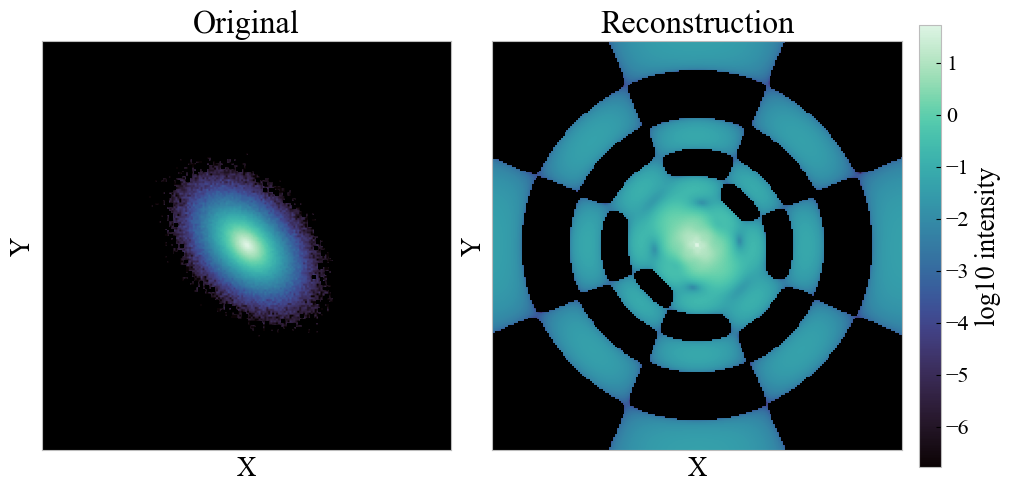

In [ ]:
# parameters
N = 1000000
a = 6                    # reconstruction scale as requested
rmax = 212/2
nbins = 212
noise = 0.0
mmax, nmax = 6, 10
# generate galaxy
D = DiscGalaxy(N=N, a=a, M=3951.4895)
D.rotate_disc(50, 0, 90+45)   # inc=50, PA=45
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()
orig_imgs.append(img_orig)

# --- Laguerre expansion & reconstruction on the same grid ---
E1 = D.make_expansion(mmax, nmax, a, noisy=False)
E1.laguerre_reconstruction(D.r, D.p)   # produces E1.reconstruction on a point set

# Map reconstruction back to the image grid via histogramming
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
x_flat = X2.ravel()
y_flat = Y2.ravel()
w_flat = E1.reconstruction.ravel()

recon_img, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges],
    weights=w_flat
)
counts, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges]
)

# avoid divide-by-zero; normalize total flux to the original image
recon_img = recon_img / np.maximum(counts, 1)
# match total intensity
total_recon = np.sum(recon_img)
if total_recon > 0:
    recon_img *= np.sum(img_orig) / total_recon

recon_img = recon_img.T  # to match imshow orientation
recon_imgs.append(recon_img)

# --- Plot side by side ---
cmap = sns.color_palette("mako", as_cmap=True)
orig_log = np.log10(np.where(img_orig > 0, img_orig, np.nan))
recon_log = np.log10(np.where(recon_img > 0, recon_img, np.nan))

fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

for ax, im, title in zip(axes, [orig_log, recon_log], ["Original", "Reconstruction"]):
    h = ax.imshow(im, extent=extent, cmap=cmap, origin="lower")
    ax.set_title(title)
    ax.set(facecolor = "black")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")

cbar = fig.colorbar(h, ax=axes, shrink=0.9, pad=0.02)
cbar.set_label("log10 intensity")

plt.show()


<>:137: SyntaxWarning: invalid escape sequence '\e'
<>:137: SyntaxWarning: invalid escape sequence '\e'
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_94341/3846659651.py:137: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(incl_list, eta_avg_list, color='teal', label='Model $\eta$ and Inclination')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/labellines/core.py:267: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=0.005284220604786949, xmax=0.005284220604787004, xval=0.04833222230888523). Clipping it into the allowed range.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/labellines/core.py:267: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=0.005280935178788526, xmax=0.005280935178788526, xval=0.08555560594102127). Clipping it into the allowed range.
  warnings.warn(
/Library/Framew

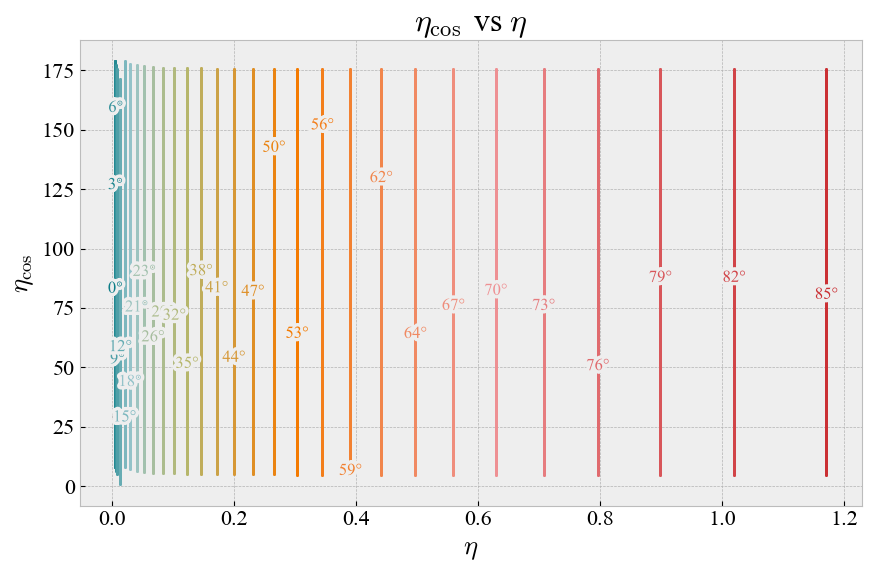


=== Cosine + Exponential Fit ===
A = -1.9953 ± 6.4738
B = -0.6074 ± 0.9884
C = 6.3229 ± 0.0719
D = 2.0000 ± 6.4746
E = 0.0005 ± 0.0007
F = 0.0795 ± 0.0117
RMSE = 0.0015


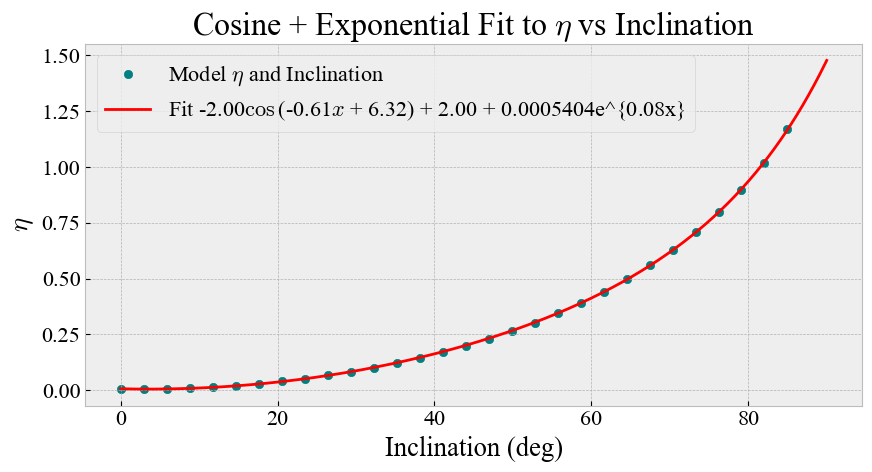

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
incl_list = np.linspace(0, 85, 30)   # inclinations to sample
PA_list   = np.linspace(0, 180, 20)    # PAs to sample
colorindx = np.linspace(0, 1, len(incl_list) + 1)  # FIX: len(incl_list)+1
N = 1000000
a = 6                    # reconstruction scale as requested
rmax = 212/2
h=212
w=212
nbins = 212
noise = 0.0
mmax, nmax = 10, 10
incs = [0, 30, 45, 60, 90]
PAs= [0, 30, 45, 60, 90]  # Position angles in degrees
x_edges = np.linspace(-rmax, rmax, nbins + 1)
y_edges = np.linspace(-rmax, rmax, nbins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
D = DiscGalaxy(N=N, a=a,M=3951.4895 )
D.rotate_disc(40, 0, 9)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()

gray=img_orig.copy() 
rmaxx = h // 2
rmaxy = w // 2

radius=h//4
cx, cy = w//2, h//2
y, x = np.indices((h,w))
mask = (x - cx)**2 + (y - cy)**2 <= radius**2
gray = np.where(mask, gray, 0.0)
x_edges = np.linspace(-rmaxy, rmaxy, w + 1)
y_edges = np.linspace(-rmaxx, rmaxx, h + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')


plt.figure(figsize=(9, 6))
eta_avg_list = []
for i, inc in enumerate(incl_list):
    etas, eta_cos_list, eta_sin_list = [], [], []
    for PA in PA_list:
        D = DiscGalaxy(N=N, a=a, M=3333)
        D.rotate_disc(inc, 0, PA)
        D.generate_image(rmax=min(rmaxx, rmaxy), nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, a)

        coscoefs = E.coscoefs
        sincoefs = E.sincoefs

        denom = np.sqrt(np.sum([coscoefs[0, n]**2 for n in range(nmax)]))
        denom = denom if denom != 0.0 else np.nan

        # Numerator: combined magnitude of m=2 cosine+sin coefficients
        num = np.sqrt(np.sum([coscoefs[2, n]**2 + sincoefs[2, n]**2 for n in range(nmax)]))

        num_cos = np.sign(coscoefs[2, 0]) * sum(abs(coscoefs[2, n]) for n in range(nmax))
        num_sin = np.sign(sincoefs[2, 0]) * sum(abs(sincoefs[2, n]) for n in range(nmax))

        eta     = num / denom
        eta_cos = num_cos / denom
        eta_sin = num_sin / denom
        eta_cos=90-(np.arctan2(sincoefs[2,0],coscoefs[2,0])* 180/np.pi)/2

        etas.append(eta)
        eta_cos_list.append(eta_cos)
        eta_sin_list.append(eta_sin)

    eta_avg = np.nanmean(etas)
    eta_avg_list.append(eta_avg)
    plt.plot(etas, eta_cos_list, '-', label=f"{inc:.0f}°", color=my_gradient(colorindx[i]))

plt.xlabel(r"$\eta$")
labelLines(plt.gca().get_lines(), align=False, fontsize=12)
plt.ylabel(r"$\eta_{\cos}$")
plt.title(r"$\eta_{\cos}$ vs $\eta$")
plt.grid(True)
plt.tight_layout()
plt.show()
# ================================================
# 1) Define improved model: Cosine + Exponential
# ================================================
def cos_plus_exp(x_deg, A, B, C, D, E, F):
    """
    A * cos(B * radians(x) + C) + D + E * exp(F * x)
    Combines an oscillatory term with a rising exponential tail.
    """
    x_rad = np.deg2rad(x_deg)
    return A * np.cos(B * x_rad + C) + D + E * np.exp(F * x_deg)


# ================================================
# 2) Initial guesses and bounds
# ================================================
p0 = [-0.3, -1.65, 6.43, 0.32, 0.01, 0.05]

lower = [-2.0, -10.0, -10.0, -1.0, -10.0, -1.0]
upper = [ 2.0,  10.0,  10.0,  2.0,  10.0,  1.0]

params, covariance = curve_fit(
    cos_plus_exp, xdata, ydata,
    p0=p0, bounds=(lower, upper),
    maxfev=100_000
)

A_fit, B_fit, C_fit, D_fit, E_fit, F_fit = params
errors = np.sqrt(np.diag(covariance))

print("\n=== Cosine + Exponential Fit ===")
print(f"A = {A_fit:.4f} ± {errors[0]:.4f}")
print(f"B = {B_fit:.4f} ± {errors[1]:.4f}")
print(f"C = {C_fit:.4f} ± {errors[2]:.4f}")
print(f"D = {D_fit:.4f} ± {errors[3]:.4f}")
print(f"E = {E_fit:.4f} ± {errors[4]:.4f}")
print(f"F = {F_fit:.4f} ± {errors[5]:.4f}")

# ================================================
# 4) Generate fit curve for plotting
# ================================================
inc_fit = np.linspace(0, 90, 500)
eta_fit = cos_plus_exp(inc_fit, *params)

# Compute residuals and RMSE for diagnostics
residuals = ydata - cos_plus_exp(xdata, *params)
rmse = np.sqrt(np.mean(residuals**2))
print(f"RMSE = {rmse:.4f}")

# ================================================
# 5) Plot results
# ================================================
plt.figure(figsize=(9, 5))
plt.scatter(incl_list, eta_avg_list, color='teal', label='Model $\eta$ and Inclination')
plt.plot(inc_fit, eta_fit, 'r-', lw=2,
         label=rf'Fit {A_fit:.2f}$\cos$({B_fit:.2f}$x$ + {C_fit:.2f}) + {D_fit:.2f} + {E_fit:.7f}e^{{{F_fit:.2f}x}}')

plt.xlabel('Inclination (deg)')
plt.ylabel(r'$\eta$')
plt.title(r'Cosine + Exponential Fit to $\eta$ vs Inclination')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<>:118: SyntaxWarning: invalid escape sequence '\e'
<>:118: SyntaxWarning: invalid escape sequence '\e'
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_5641/2517076360.py:118: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(incl_list, eta_avg_list, color='teal', label='Model $\eta$ and Inclination')
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_5641/2517076360.py:118: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(incl_list, eta_avg_list, color='teal', label='Model $\eta$ and Inclination')


KeyboardInterrupt: 

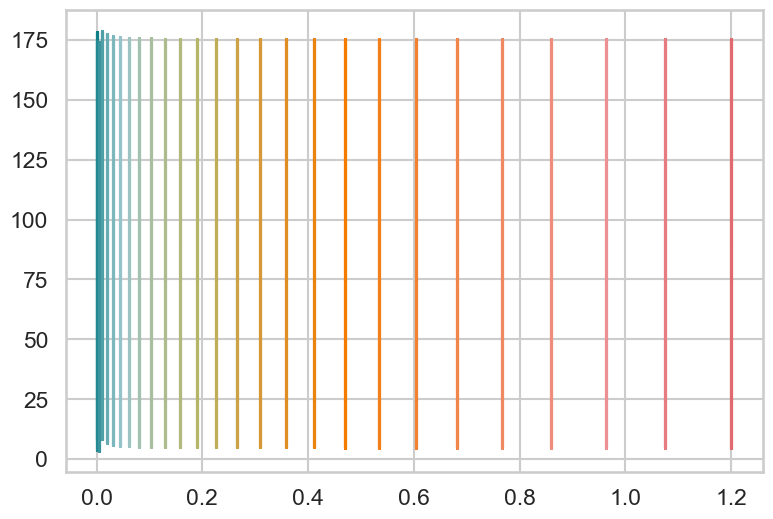

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
incl_list = np.linspace(0, 85, 30)   # inclinations to sample
PA_list   = np.linspace(0, 180, 20)    # PAs to sample
colorindx = np.linspace(0, 1, len(incl_list) + 1)  # FIX: len(incl_list)+1
N = 1000000
a = 6                    # reconstruction scale as requested
rmax = 212/2
h=212
w=212
nbins = 212
noise = 0.0
mmax, nmax = 10, 10
incs = [0, 30, 45, 60, 90]
PAs= [0, 30, 45, 60, 90]  # Position angles in degrees
x_edges = np.linspace(-rmax, rmax, nbins + 1)
y_edges = np.linspace(-rmax, rmax, nbins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
D = DiscGalaxy(N=N, a=a,M=3951.4895 )
D.rotate_disc(40, 0, 9)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()

gray=img_orig.copy() 
rmaxx = h // 2
rmaxy = w // 2

radius=h//4
cx, cy = w//2, h//2
y, x = np.indices((h,w))
mask = (x - cx)**2 + (y - cy)**2 <= radius**2
gray = np.where(mask, gray, 0.0)
x_edges = np.linspace(-rmaxy, rmaxy, w + 1)
y_edges = np.linspace(-rmaxx, rmaxx, h + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')


plt.figure(figsize=(9, 6))
eta_avg_list = []
for i, inc in enumerate(incl_list):
    etas, eta_cos_list, eta_sin_list = [], [], []
    for PA in PA_list:
        D = DiscGalaxy(N=N, a=a, M=3333)
        D.rotate_disc(inc, 0, PA)
        D.generate_image(rmax=min(rmaxx, rmaxy), nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, a)

        coscoefs = E.coscoefs
        sincoefs = E.sincoefs

        denom = np.sqrt(np.sum([coscoefs[0, n]**2 for n in range(nmax)]))
        denom = denom if denom != 0.0 else np.nan

        # Numerator: combined magnitude of m=2 cosine+sin coefficients
        num = np.sqrt(np.sum([coscoefs[2, n]**2 + sincoefs[2, n]**2 for n in range(nmax)]))

        num_cos = np.sign(coscoefs[2, 0]) * sum(abs(coscoefs[2, n]) for n in range(nmax))
        num_sin = np.sign(sincoefs[2, 0]) * sum(abs(sincoefs[2, n]) for n in range(nmax))

        eta     = num / denom
        eta_cos = num_cos / denom
        eta_sin = num_sin / denom
        eta_cos=90-(np.arctan2(sincoefs[2,0],coscoefs[2,0])* 180/np.pi)/2

        etas.append(eta)
        eta_cos_list.append(eta_cos)
        eta_sin_list.append(eta_sin)

    eta_avg = np.nanmean(etas)
    eta_avg_list.append(eta_avg)
    plt.plot(etas, eta_cos_list, '-', label=f"{inc:.0f}°", color=my_gradient(colorindx[i]))

plt.xlabel(r"$\eta$")
labelLines(plt.gca().get_lines(), align=False, fontsize=12)
plt.ylabel(r"$\eta_{\cos}$")
plt.title(r"$\eta_{\cos}$ vs $\eta$")
plt.grid(True)
plt.tight_layout()
plt.show()



def cos_plus_exp(x_deg, A, B, C, D):
    x_rad = np.deg2rad(x_deg)
    return A * np.cos(B * x_rad + C) + D 

p0 = [-0.3, -1.65, 6.2, 0.32]  # adjusted C
lower = [-2.0, -10.0, -2*np.pi, -1.0]
upper = [ 2.0,  10.0,  2*np.pi + 1,  2.0]  # slightly wider bound

mask = ~np.isnan(eta_avg_list)
xdata = np.array(incl_list)[mask]
ydata = np.array(eta_avg_list)[mask]

params, covariance = curve_fit(
    cos_plus_exp, xdata, ydata,
    p0=p0, bounds=(lower, upper), maxfev=100_000
)

A_fit, B_fit, C_fit, D_fit,t = params
errors = np.sqrt(np.diag(covariance))

print("\n=== Cosine + Exponential Fit ===")
for name, val, err in zip(['A','B','C','D'], params, errors):
    print(f"{name} = {val:.4f} ± {err:.4f}")

inc_fit = np.linspace(0, 90, 500)
eta_fit = cos_plus_exp(inc_fit, *params)
rmse = np.sqrt(np.mean((ydata - cos_plus_exp(xdata, *params))**2))
print(f"RMSE = {rmse:.4f}")

plt.figure(figsize=(9,5))
plt.scatter(incl_list, eta_avg_list, color='teal', label='Model $\eta$ and Inclination')
plt.plot(inc_fit, eta_fit, 'r-', lw=2,
         label=rf'Fit: $A\cos(Bx+C)+D$')
plt.xlabel('Inclination (deg)')
plt.ylabel(r'$\eta$')
plt.title(r'Cosine Fit to $\eta$ vs Inclination')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
from scipy.optimize import root_scalar
import numpy as np

def cos_plus_exp(x_deg, A, B, C, D, E, F):
    x_rad = np.deg2rad(x_deg)
    return A * np.cos(B * x_rad + C) + D + E * np.exp(F * x_deg)


def find_inclination_from_eta(eta_target, A, B, C, D, E, F, 
                              search_range=(0, 90), tol=1e-6, verbose=False):
    """
    Numerically invert the cosine+exponential fit.
    Returns inclination angle (deg) for a given η value.
    """

    def f(x):
        return cos_plus_exp(x, A, B, C, D, E, F) - eta_target

    # Check range validity
    x_min, x_max = search_range
    fmin, fmax = f(x_min), f(x_max)
    if np.sign(fmin) == np.sign(fmax):
        if verbose:
            print("⚠️ Eta target is outside model range, extrapolating.")
        # fall back to best-fit (minimization)
        x_grid = np.linspace(x_min, x_max, 2000)
        vals = np.abs(f(x_grid))
        return x_grid[np.argmin(vals)]

    sol = root_scalar(f, bracket=[x_min, x_max], method='brentq', xtol=tol)
    if not sol.converged:
        raise RuntimeError("Root finding failed to converge.")
    return sol.root



In [12]:


from flex import FLEX

from scipy.stats import linregress
from astropy.io import fits
from astropy.wcs import WCS

import numpy as np


from scipy.optimize import root_scalar
    
def galaxymorphology(file,galaxy=None,data=None,noisefloor=-5.):

    if data is not None and galaxy is None:
        raise ValueError("If 'data' is provided, 'galaxy' must also be defined.")
    
    def cos_plus_exp(x_deg, A, B, D, E, F):
        x_rad = np.deg2rad(x_deg)
        
        return A * np.cos(B * x_rad) + D + E * np.exp(F * x_deg)


    def find_inclination_from_eta(eta_target, A, B, D, E, F, 
                                search_range=(0, 90), tol=1e-6, verbose=False):
        """Numerically invert the cosine+exponential fit."""
        def f(x):
            return cos_plus_exp(x, A, B, D, E, F) - eta_target

        x_min, x_max = search_range
        fmin, fmax = f(x_min), f(x_max)
        if np.sign(fmin) == np.sign(fmax):
            if verbose:
                print("Eta target is outside model range, extrapolating.")
            x_grid = np.linspace(x_min, x_max, 2000)
            vals = np.abs(f(x_grid))
            return x_grid[np.argmin(vals)]

        sol = root_scalar(f, bracket=[x_min, x_max], method='brentq', xtol=tol)
        if not sol.converged:
            raise RuntimeError("Root finding failed to converge.")
        return sol.root
    
    
    with fits.open(file) as hdulist:
        image_data = hdulist[1].data

        if data is not None:
            ra = data['RA_LEDA'][data['GALAXY']==galaxy]
            dec = data['DEC_LEDA'][data['GALAXY']==galaxy]

            wcs = WCS(hdulist[1].header)
            pixel_coords = wcs.world_to_pixel_values(ra, dec)
            #print("Pixel coordinates (x, y):", pixel_coords)
        
    galaxy_name = file.split("-")[0]
    h, w = image_data.shape

    gray=image_data.copy() 
    rmaxx = h // 2
    rmaxy = w // 2
   
    # this choice of radius is a hyperparameter -- we may want to tune it
    radius=h//4

    if data is None:
        cx, cy = w//2, h//2
    else:   
        cx, cy = pixel_coords[0], pixel_coords[1]


    y, x = np.indices((h,w))
    mask = (x - cx)**2 + (y - cy)**2 <= radius**2
    gray = np.where(mask, gray, 0.0)

    X2,Y2 = (y-cx), (x-cy)

    R = np.sqrt(X2**2 + Y2**2).ravel()
    I = image_data.ravel()

    valid = (I > 0) & (R <= radius)
    R_valid = R[valid]
    I_valid = I[valid]
    #print(y,x)

    rindx = R_valid.argsort()
    R_sorted = R_valid[rindx]
    I_sorted = I_valid[rindx]

    # generate a moving average
    window_size = 100 # this is a hyperparameter
    means_R = np.convolve(R_sorted, np.ones(window_size)/window_size, mode='valid')
    means_I = np.convolve(I_sorted, np.ones(window_size)/window_size, mode='valid')
    
    # set the floor for noise
    # if this fails ... use outermost radius
   
    indices_below_noise = np.where(np.log(np.clip(means_I, 1e-10, None)) < noisefloor)[0]
    if len(indices_below_noise) > 0:
        maxrad = means_R[indices_below_noise[0]]
    else:
        maxrad = means_R[-1]
    
    valid = (I > 0) & (R <= maxrad)
    R_valid = R[valid]
    logI_valid = np.log(I[valid])
   
    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(R_valid, logI_valid)
    scale_length = -1 / slope
    if scale_length < 0:
        scale_length = 50
    if scale_length > 100:
        scale_length = 30
    
    a=scale_length*1.5

    R,P = np.sqrt(X2**2 + Y2**2), np.arctan2(Y2, X2)

    mmax, nmax = 8, 10


    L = FLEX(a,mmax,nmax, R.flatten(), P.flatten(), mass=image_data.flatten())
    
    c1 = L.coscoefs; s1 = L.sincoefs
   
    num = np.linalg.norm(np.sqrt(L.coscoefs[2]**2 + L.sincoefs[2]**2))
    den = np.linalg.norm(L.coscoefs[0])

    eta_bt     = num/den
    
    A_fit = -1.9953 
    B_fit = -0.6074 
    D_fit = 2.0000 
    E_fit = 0.0005
    F_fit = 0.0795 
    
    inc_bt=find_inclination_from_eta(eta_bt,A_fit,B_fit,D_fit,E_fit,F_fit,verbose=True)
    
    phi=np.arctan2(s1[2,0],c1[2,0])
  
    if phi < 0 :
        phi= -np.pi - 1*phi
    else:
        phi=np.pi- 1*phi 
    PA=90+(phi* 180/np.pi)/2
  
    return inc_bt, PA, galaxy_name, a, eta_bt, maxrad, radius


    


In [15]:
Name=[]
Inc=[]
PA=[]
fits_files = glob.glob('zfits/*.fits.fz')
for idx, file in enumerate(fits_files):
    A=galaxymorphology(fits_files[idx])
    Name.append(A[2])
    Inc.append(A[0])
    PA.append(A[1])
    print(f"Processed {A[2]}: Inc={A[0]:.2f}, PA={A[1]:.2f}")

Processed zfits/NGC3556: Inc=75.09, PA=76.99
Processed zfits/NGC4359: Inc=71.74, PA=109.51
Processed zfits/NGC6217: Inc=53.16, PA=150.46
Processed zfits/NGC3403: Inc=66.29, PA=74.99
Processed zfits/NGC3118: Inc=64.09, PA=38.96
Processed zfits/NGC6140: Inc=69.95, PA=86.35
Processed zfits/NGC6186: Inc=54.50, PA=52.67
Processed zfits/NGC5289: Inc=59.88, PA=99.51
Processed zfits/NGC4203: Inc=35.48, PA=8.20
Processed zfits/NGC2776: Inc=24.77, PA=136.94
Processed zfits/NGC2893: Inc=38.47, PA=161.92
Processed zfits/NGC3310: Inc=27.38, PA=168.97
Processed zfits/NGC4369: Inc=53.82, PA=151.38
Processed zfits/NGC5676: Inc=55.53, PA=41.67
Processed zfits/NGC4100: Inc=69.15, PA=166.75
Processed zfits/NGC3726: Inc=57.73, PA=22.80
Processed zfits/NGC5112: Inc=63.16, PA=124.88
Processed zfits/NGC5879: Inc=65.34, PA=3.35
Processed zfits/NGC6667: Inc=56.66, PA=98.88
Processed zfits/NGC4051: Inc=57.21, PA=131.23
Processed zfits/NGC3147: Inc=33.23, PA=111.56
Processed zfits/NGC3206: Inc=56.63, PA=80.95
Pr

In [16]:
Name=[]
Inc=[]
PA=[]
fits_files = glob.glob('Gfits/*.fits.fz')
for idx, file in enumerate(fits_files):
    A=galaxymorphology(fits_files[idx])
    Name.append(A[2])
    Inc.append(A[0])
    PA.append(A[1])
    print(f"Processed {A[2]}: Inc={A[0]:.2f}, PA={A[1]:.2f}")

Processed Gfits/NGC5289: Inc=50.40, PA=99.16
Processed Gfits/NGC6186: Inc=55.94, PA=57.44
Processed Gfits/NGC3310: Inc=32.79, PA=4.93
Processed Gfits/NGC2893: Inc=36.72, PA=160.33
Processed Gfits/NGC2776: Inc=44.78, PA=130.36
Processed Gfits/NGC4203: Inc=80.74, PA=4.40
Processed Gfits/NGC5676: Inc=61.61, PA=41.85
Processed Gfits/NGC4369: Inc=57.38, PA=147.87
Processed Gfits/NGC4100: Inc=83.70, PA=163.77
Processed Gfits/NGC5112: Inc=63.32, PA=127.00
Processed Gfits/NGC3726: Inc=56.25, PA=20.91
Processed Gfits/NGC4359: Inc=74.58, PA=109.78
Processed Gfits/NGC3556: Inc=79.36, PA=79.64
Processed Gfits/NGC6217: Inc=41.04, PA=151.65
Processed Gfits/NGC3403: Inc=81.22, PA=74.51
Processed Gfits/NGC6140: Inc=78.83, PA=62.88
Processed Gfits/NGC3118: Inc=69.52, PA=38.25
Processed Gfits/NGC4051: Inc=67.53, PA=140.02
Processed Gfits/NGC2985: Inc=40.19, PA=165.59
Processed Gfits/NGC3206: Inc=70.27, PA=37.43
Processed Gfits/NGC3147: Inc=36.27, PA=121.53
Processed Gfits/NGC4559: Inc=66.57, PA=132.00
P

In [17]:
Name=[]
Inc=[]
PA=[]
fits_files = glob.glob('rfits/*.fits.fz')
for idx, file in enumerate(fits_files):
    A=galaxymorphology(fits_files[idx])
    Name.append(A[2])
    Inc.append(A[0])
    PA.append(A[1])
    print(f"Processed {A[2]}: Inc={A[0]:.2f}, PA={A[1]:.2f}")

Processed rfits/NGC5289: Inc=46.91, PA=99.47
Processed rfits/NGC6186: Inc=54.69, PA=55.13
Processed rfits/NGC2893: Inc=35.58, PA=159.71
Processed rfits/NGC3310: Inc=26.40, PA=8.75
Processed rfits/NGC4203: Inc=67.90, PA=7.13
Processed rfits/NGC2776: Inc=38.85, PA=131.29
Processed rfits/NGC4369: Inc=53.19, PA=147.68
Processed rfits/NGC5676: Inc=57.57, PA=43.19
Processed rfits/NGC5112: Inc=61.47, PA=127.02
Processed rfits/NGC3726: Inc=55.67, PA=21.84
Processed rfits/NGC4100: Inc=82.51, PA=163.80
Processed rfits/NGC4359: Inc=72.99, PA=109.58
Processed rfits/NGC3556: Inc=77.03, PA=77.55
Processed rfits/NGC3403: Inc=73.39, PA=74.10
Processed rfits/NGC6217: Inc=46.76, PA=145.46
Processed rfits/NGC6140: Inc=79.35, PA=64.42
Processed rfits/NGC3118: Inc=67.55, PA=38.89
Processed rfits/NGC4051: Inc=63.86, PA=139.37
Processed rfits/NGC4559: Inc=64.34, PA=132.86
Processed rfits/NGC3206: Inc=65.35, PA=40.28
Processed rfits/NGC2985: Inc=39.42, PA=177.99
Processed rfits/NGC3147: Inc=43.67, PA=113.86
P

In [11]:
Name=[]
Inc=[]
PA=[]
fits_files = glob.glob('data/gfits3/*.fits.fz')
for idx, file in enumerate(fits_files):
    A=galaxymorphology(fits_files[idx])
    Name.append(A[2])
    Inc.append(A[0])
    PA.append(A[1])
    print(f"Processed {A[2]}: Inc={A[0]:.2f}, PA={A[1]:.2f}")

Processed data/gfits3/NGC5289: Inc=50.40, PA=99.16
Processed data/gfits3/NGC6186: Inc=55.94, PA=57.44
Processed data/gfits3/NGC3310: Inc=32.79, PA=4.93
Processed data/gfits3/NGC2893: Inc=36.72, PA=160.33
Processed data/gfits3/NGC2776: Inc=44.78, PA=130.36
Processed data/gfits3/NGC4203: Inc=80.74, PA=4.40
Processed data/gfits3/NGC5676: Inc=61.61, PA=41.85
Processed data/gfits3/NGC4369: Inc=57.38, PA=147.87
Processed data/gfits3/NGC4100: Inc=83.70, PA=163.77
Processed data/gfits3/NGC5112: Inc=63.32, PA=127.00
Processed data/gfits3/NGC3726: Inc=56.25, PA=20.91
Processed data/gfits3/NGC4359: Inc=74.58, PA=109.78
Processed data/gfits3/NGC3556: Inc=79.36, PA=79.64
Processed data/gfits3/NGC6217: Inc=41.04, PA=151.65
Processed data/gfits3/NGC3403: Inc=81.22, PA=74.51
Processed data/gfits3/NGC6140: Inc=78.83, PA=62.88
Processed data/gfits3/NGC3118: Inc=69.52, PA=38.25
Processed data/gfits3/NGC4051: Inc=67.53, PA=140.02
Processed data/gfits3/NGC2985: Inc=40.19, PA=165.59
Processed data/gfits3/NG

In [42]:

        
        


from flex import FLEX

from scipy.stats import linregress
from astropy.io import fits
from astropy.wcs import WCS

import numpy as np


from scipy.optimize import root_scalar
    
def galaxymorphology(file,galaxy=None,data=None,noisefloor=-5.):

    if data is not None and galaxy is None:
        raise ValueError("If 'data' is provided, 'galaxy' must also be defined.")
    
    def cos_plus_exp(x_deg, A, B, D):
        x_rad = np.deg2rad(x_deg)
        return A * np.cos(B * x_rad) + D 


    def find_inclination_from_eta(eta, A, B, D):
        x=1/B*(np.arccos((eta-D)/A))
        inc= -np.rad2deg(x)
        return inc
    
    
    with fits.open(file) as hdulist:
        image_data = hdulist[1].data

        if data is not None:
            ra = data['RA_LEDA'][data['GALAXY']==galaxy]
            dec = data['DEC_LEDA'][data['GALAXY']==galaxy]

            wcs = WCS(hdulist[1].header)
            pixel_coords = wcs.world_to_pixel_values(ra, dec)
            #print("Pixel coordinates (x, y):", pixel_coords)
        
    galaxy_name = file.split("-")[0]
    h, w = image_data.shape

    gray=image_data.copy() 
    rmaxx = h // 2
    rmaxy = w // 2
   
    # this choice of radius is a hyperparameter -- we may want to tune it
    radius=h//4

    if data is None:
        cx, cy = w//2, h//2
    else:   
        cx, cy = pixel_coords[0], pixel_coords[1]


    y, x = np.indices((h,w))
    mask = (x - cx)**2 + (y - cy)**2 <= radius**2
    gray = np.where(mask, gray, 0.0)

    X2,Y2 = (y-cx), (x-cy)

    R = np.sqrt(X2**2 + Y2**2).ravel()
    I = image_data.ravel()

    valid = (I > 0) & (R <= radius)
    R_valid = R[valid]
    I_valid = I[valid]
    #print(y,x)

    rindx = R_valid.argsort()
    R_sorted = R_valid[rindx]
    I_sorted = I_valid[rindx]

    # generate a moving average
    window_size = 100 # this is a hyperparameter
    means_R = np.convolve(R_sorted, np.ones(window_size)/window_size, mode='valid')
    means_I = np.convolve(I_sorted, np.ones(window_size)/window_size, mode='valid')
    
    # set the floor for noise
    # if this fails ... use outermost radius
   
    indices_below_noise = np.where(np.log(np.clip(means_I, 1e-10, None)) < noisefloor)[0]
    if len(indices_below_noise) > 0:
        maxrad = means_R[indices_below_noise[0]]
    else:
        maxrad = means_R[-1]
    
    valid = (I > 0) & (R <= maxrad)
    R_valid = R[valid]
    logI_valid = np.log(I[valid])
   
    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(R_valid, logI_valid)
    scale_length = -1 / slope
    if scale_length < 0:
        scale_length = 50
    if scale_length > 100:
        scale_length = 30
    
    a=scale_length*1.5

    R,P = np.sqrt(X2**2 + Y2**2), np.arctan2(Y2, X2)

    mmax, nmax = 8, 10


    L = FLEX(a,mmax,nmax, R.flatten(), P.flatten(), mass=image_data.flatten())
    
    c1 = L.coscoefs; s1 = L.sincoefs
   
    num = np.linalg.norm(np.sqrt(L.coscoefs[2]**2 + L.sincoefs[2]**2))
    den = np.linalg.norm(L.coscoefs[0])

    eta_bt     = num/den
    A_fit = -1.9953 
    B_fit = -0.6074 
    D_fit = 2.0000 

    inc_bt=find_inclination_from_eta(eta_bt,A_fit,B_fit,D_fit)
   
    phi=np.arctan2(s1[2,0],c1[2,0])
  
    if phi < 0 :
        phi= -np.pi - 1*phi
    else:
        phi=np.pi- 1*phi 
    PA=90+(phi* 180/np.pi)/2
  
    return inc_bt, PA, galaxy_name, a, eta_bt, maxrad, radius


    


In [43]:
Name=[]
Inc=[]
PA=[]
eta=[]
fits_files = glob.glob('data/gfits3/*.fits.fz')
for idx, file in enumerate(fits_files):
    A=galaxymorphology(fits_files[idx])
    Name.append(A[2])
    Inc.append(A[0])
    PA.append(A[1])
    eta.append(A[4])
    print(f"Processed {A[2]}: Inc={A[0]:.2f}, PA={A[1]:.2f}, eta={A[4]:.4f}")

Processed data/gfits3/NGC5289: Inc=52.90, PA=99.16, eta=0.3103
Processed data/gfits3/NGC6186: Inc=59.45, PA=57.44, eta=0.3881
Processed data/gfits3/NGC3310: Inc=33.72, PA=4.93, eta=0.1308
Processed data/gfits3/NGC2893: Inc=37.85, PA=160.33, eta=0.1632
Processed data/gfits3/NGC2776: Inc=46.56, PA=130.36, eta=0.2429
Processed data/gfits3/NGC4203: Inc=98.58, PA=4.40, eta=0.9986
Processed data/gfits3/NGC5676: Inc=66.65, PA=41.85, eta=0.4824
Processed data/gfits3/NGC4369: Inc=61.22, PA=147.87, eta=0.4104
Processed data/gfits3/NGC4100: Inc=105.50, PA=163.77, eta=1.1279
Processed data/gfits3/NGC5112: Inc=68.94, PA=127.00, eta=0.5143
Processed data/gfits3/NGC3726: Inc=59.83, PA=20.91, eta=0.3928
Processed data/gfits3/NGC4359: Inc=86.38, PA=109.78, eta=0.7844
Processed data/gfits3/NGC3556: Inc=95.62, PA=79.64, eta=0.9450
Processed data/gfits3/NGC6217: Inc=42.49, PA=151.65, eta=0.2037
Processed data/gfits3/NGC3403: Inc=99.66, PA=74.51, eta=1.0185
Processed data/gfits3/NGC6140: Inc=94.51, PA=62.8

KeyboardInterrupt: 

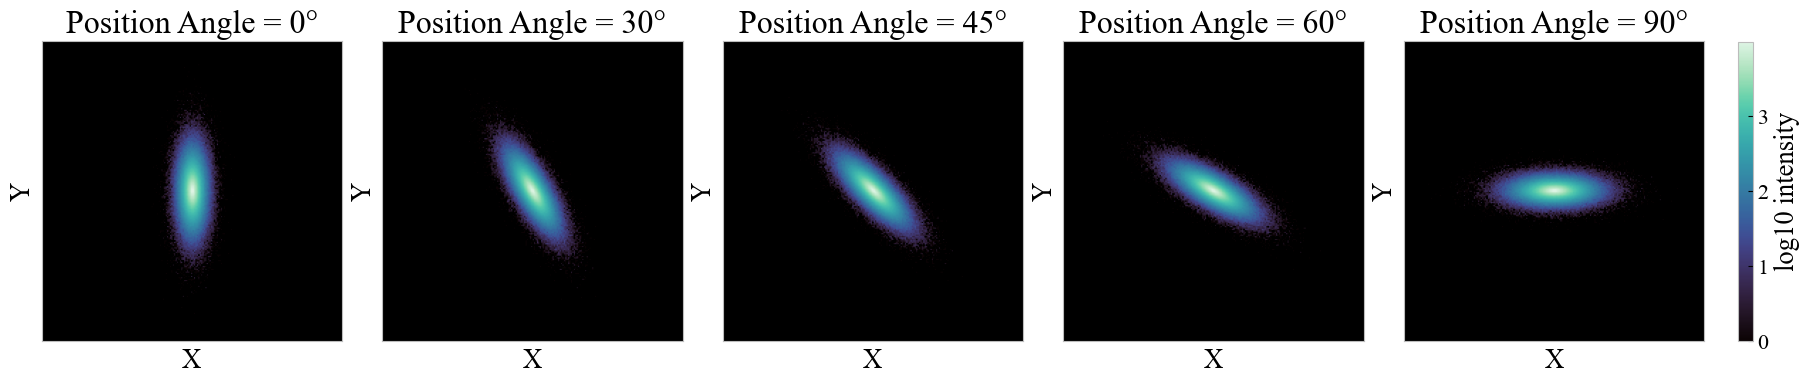

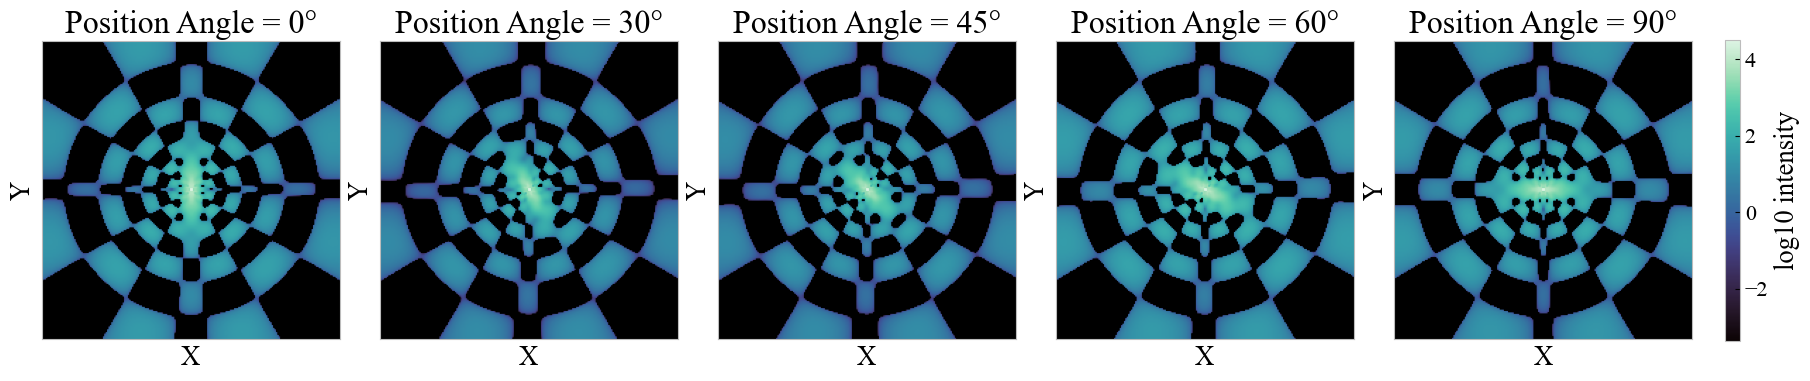

Amn (rows = n, columns = m):
[[ 413.    7.   66.    2.    9.    4.    9.]
 [ 577.    9.   92.    2.   13.    6.   12.]
 [ 696.   11.  110.    3.   16.    7.   15.]
 [ 793.   13.  124.    3.   18.    8.   16.]
 [ 874.   14.  136.    4.   20.    9.   18.]
 [ 944.   15.  146.    4.   21.   10.   19.]
 [1005.   16.  155.    4.   22.   10.   20.]
 [1059.   17.  162.    4.   24.   11.   21.]]


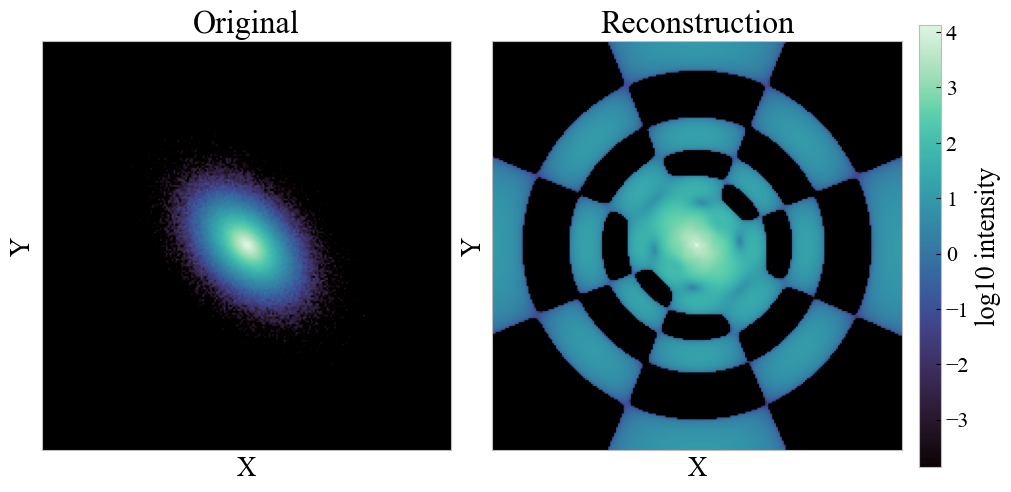

In [29]:
import seaborn as sns
N = 1000000
a = 6                    # reconstruction scale as requested
rmax = 212/2
nbins = 212
noise = 0.0
mmax, nmax = 10, 10
incs = [0, 30, 45, 60, 90]
PAs= [0, 30, 45, 60, 90]  # Position angles in degrees

# precompute grid edges/centers + extent
x_edges = np.linspace(-rmax, rmax, nbins + 1)
y_edges = np.linspace(-rmax, rmax, nbins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]

orig_imgs = []
recon_imgs = []

for PA in PAs:
    # --- simulate & get original image ---
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(70, 0, 90+PA)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    img_orig = D.img.copy()
    orig_imgs.append(img_orig)

    # --- Laguerre expansion & reconstruction on the same grid ---
    E1 = D.make_expansion(mmax, nmax, a, noisy=False)
    E1.laguerre_reconstruction(D.r, D.p)   # produces E1.reconstruction on a point set

    # Map reconstruction back to the image grid via histogramming
    X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
    x_flat = X2.ravel()
    y_flat = Y2.ravel()
    w_flat = E1.reconstruction.ravel()

    recon_img, _, _ = np.histogram2d(
        x_flat, y_flat,
        bins=[x_edges, y_edges],
        weights=w_flat
    )
    counts, _, _ = np.histogram2d(
        x_flat, y_flat,
        bins=[x_edges, y_edges]
    )

    # avoid divide-by-zero; normalize total flux to the original image
    recon_img = recon_img / np.maximum(counts, 1)
    # match total intensity
    total_recon = np.sum(recon_img)
    if total_recon > 0:
        recon_img *= np.sum(img_orig) / total_recon

    recon_img = recon_img.T  # to match imshow orientation
    recon_imgs.append(recon_img)

cmap=sns.color_palette("mako", as_cmap=True)
# --- plot: originals ---

fig1, axes1 = plt.subplots(1, len(incs), figsize=(3.6*len(incs), 3.6), constrained_layout=True)
for ax in axes1:
    ax.set(facecolor = "black")
if len(incs) == 1:
    axes1 = [axes1]
for ax, inc, im in zip(axes1, incs, orig_imgs):
    imshow_data = np.log10(np.where(im > 0, im, np.nan))
    h = ax.imshow(imshow_data, extent=extent, cmap=cmap, origin='lower')
    ax.set_title(f"Position Angle = {inc}°")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")

cbar1 = fig1.colorbar(h, ax=axes1, shrink=0.9, pad=0.02)
cbar1.set_label("log10 intensity")
    
plt.show()
# --- plot: reconstructions (a = 60) ---
fig2, axes2 = plt.subplots(1, len(incs), figsize=(3.6*len(incs), 3.6), constrained_layout=True)
for ax in axes2:
    ax.set(facecolor = "black")
if len(incs) == 1:
    axes2 = [axes2]
for ax, inc, im in zip(axes2, incs, recon_imgs):
    imshow_data = np.log10(np.where(im > 0, im, np.nan))
    h = ax.imshow(imshow_data.T, extent=extent, cmap=cmap, origin='lower')
    ax.set_title(f"Position Angle = {inc}°")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")


cbar2 = fig2.colorbar(h, ax=axes2, shrink=0.9, pad=0.02)
cbar2.set_label("log10 intensity")

plt.show()
nmax=8
mmax=6
N=10000
a=6
D = DiscGalaxy(N=N, a=a, M=3951.4895 )
D.rotate_disc(30, 0, 40)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()
orig_imgs.append(img_orig)

# --- Laguerre expansion & reconstruction on the same grid ---
E = D.make_pointexpansion(mmax, nmax, a, noisy=False)
E.laguerre_reconstruction(D.r, D.p)



coscoefs = E.coscoefs
sincoefs = E.sincoefs

Amn = np.sqrt(E.coscoefs**2 + E.sincoefs**2) 

Amn_matrix = Amn.T 

# Print matrix
print("Amn (rows = n, columns = m):")
print(np.round(Amn_matrix,0)) 




## parameters
N = 1000000
a = 6                    # reconstruction scale as requested
rmax = 212/2
nbins = 212
noise = 0.0
mmax, nmax = 6, 10
# generate galaxy
D = DiscGalaxy(N=N, a=a)
D.rotate_disc(50, 0, 90+45)   # inc=50, PA=45
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()
orig_imgs.append(img_orig)

# --- Laguerre expansion & reconstruction on the same grid ---
E1 = D.make_expansion(mmax, nmax, a, noisy=False)
E1.laguerre_reconstruction(D.r, D.p)   # produces E1.reconstruction on a point set

# Map reconstruction back to the image grid via histogramming
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
x_flat = X2.ravel()
y_flat = Y2.ravel()
w_flat = E1.reconstruction.ravel()

recon_img, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges],
    weights=w_flat
)
counts, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges]
)

# avoid divide-by-zero; normalize total flux to the original image
recon_img = recon_img / np.maximum(counts, 1)
# match total intensity
total_recon = np.sum(recon_img)
if total_recon > 0:
    recon_img *= np.sum(img_orig) / total_recon

recon_img = recon_img.T  # to match imshow orientation
recon_imgs.append(recon_img)

# --- Plot side by side ---
cmap = sns.color_palette("mako", as_cmap=True)
orig_log = np.log10(np.where(img_orig > 0, img_orig, np.nan))
recon_log = np.log10(np.where(recon_img > 0, recon_img, np.nan))

fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

for ax, im, title in zip(axes, [orig_log, recon_log], ["Original", "Reconstruction"]):
    h = ax.imshow(im, extent=extent, cmap=cmap, origin="lower")
    ax.set_title(title)
    ax.set(facecolor = "black")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")

cbar = fig.colorbar(h, ax=axes, shrink=0.9, pad=0.02)
cbar.set_label("log10 intensity")

plt.show()


<>:138: SyntaxWarning: invalid escape sequence '\e'
<>:138: SyntaxWarning: invalid escape sequence '\e'
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_5641/1103241003.py:138: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(incl_list, eta_avg_list, color=my_gradient(0), label='Model $\eta$ and Inclination')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/labellines/core.py:267: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=0.001502634320330376, xmax=0.0015026343203305426, xval=0.06281716832794362). Clipping it into the allowed range.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/labellines/core.py:267: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=0.001751360695838533, xmax=0.0017513606958385886, xval=0.11583148157470088). Clipping it into the allowed range.
  warnings.warn(
/Libra

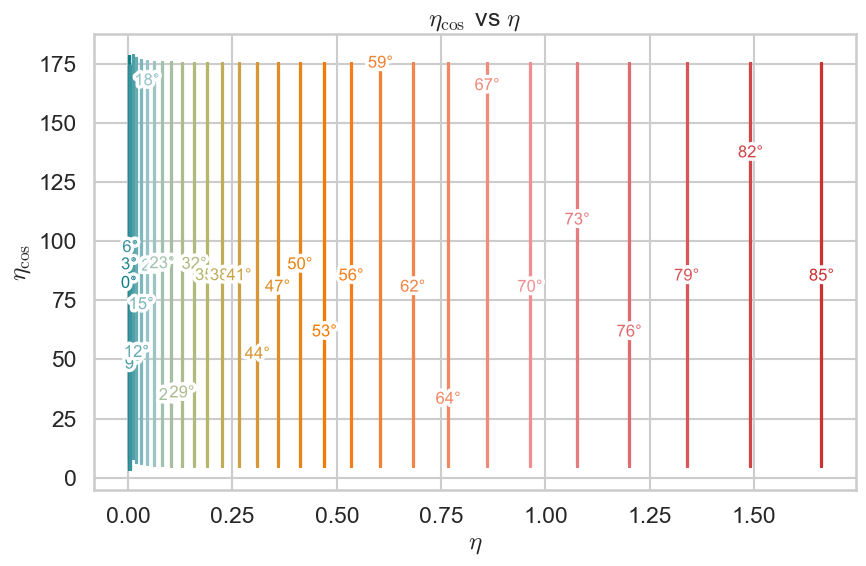


=== Cosine + Exponential Fit ===
A = -2.0000 ± 6.1172
B = -0.6222 ± 0.9144
C = 6.3240 ± 0.0837
D = 1.9808 ± 6.1307
E = 0.0183 ± 0.0117
F = 0.0465 ± 0.0041
RMSE = 0.0002


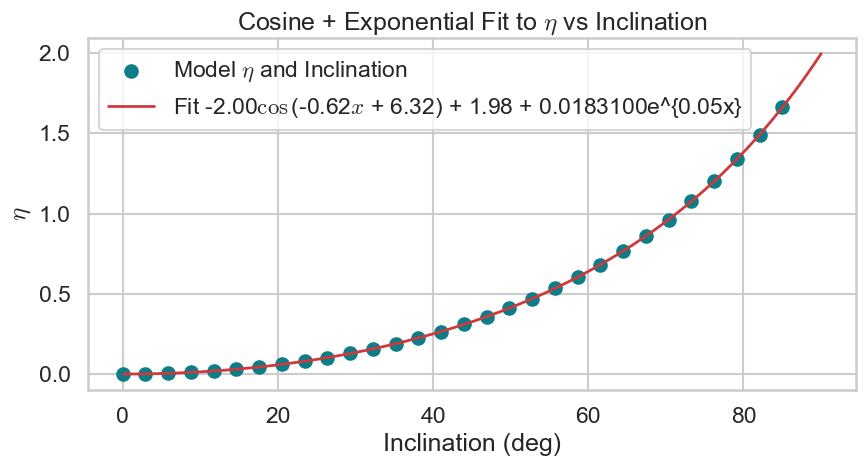

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
incl_list = np.linspace(0, 85, 30)   # inclinations to sample
PA_list   = np.linspace(0, 180, 20)    # PAs to sample
colorindx = np.linspace(0, 1, len(incl_list) + 1)  # FIX: len(incl_list)+1
N = 1000000
a = 6                    # reconstruction scale as requested
rmax = 212/2
h=212
w=212
nbins = 212
noise = 0.0
mmax, nmax = 10, 10
incs = [0, 30, 45, 60, 90]
PAs= [0, 30, 45, 60, 90]  # Position angles in degrees
x_edges = np.linspace(-rmax, rmax, nbins + 1)
y_edges = np.linspace(-rmax, rmax, nbins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
D = DiscGalaxy(N=N, a=a,M=3951.4895 )
D.rotate_disc(40, 0, 9)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()

gray=img_orig.copy() 
rmaxx = h // 2
rmaxy = w // 2

radius=h//4
cx, cy = w//2, h//2
y, x = np.indices((h,w))
mask = (x - cx)**2 + (y - cy)**2 <= radius**2
gray = np.where(mask, gray, 0.0)
x_edges = np.linspace(-rmaxy, rmaxy, w + 1)
y_edges = np.linspace(-rmaxx, rmaxx, h + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')


plt.figure(figsize=(9, 6))
eta_avg_list = []
for i, inc in enumerate(incl_list):
    etas, eta_cos_list, eta_sin_list = [], [], []
    for PA in PA_list:
        D = DiscGalaxy(N=N, a=a, M=3333)
        D.rotate_disc(inc, 0, PA)
        D.generate_image(rmax=min(rmaxx, rmaxy), nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, a)

        coscoefs = E.coscoefs
        sincoefs = E.sincoefs

        denom = np.sqrt(np.sum([coscoefs[0, n]**2 for n in range(nmax)]))
        denom = denom if denom != 0.0 else np.nan

        # Numerator: combined magnitude of m=2 cosine+sin coefficients
        num = np.sqrt(np.sum([coscoefs[2, n]**2 + sincoefs[2, n]**2 for n in range(nmax)]))

        num_cos = np.sign(coscoefs[2, 0]) * sum(abs(coscoefs[2, n]) for n in range(nmax))
        num_sin = np.sign(sincoefs[2, 0]) * sum(abs(sincoefs[2, n]) for n in range(nmax))

        eta     = num / denom
        eta_cos = num_cos / denom
        eta_sin = num_sin / denom
        eta_cos=90-(np.arctan2(sincoefs[2,0],coscoefs[2,0])* 180/np.pi)/2

        etas.append(eta)
        eta_cos_list.append(eta_cos)
        eta_sin_list.append(eta_sin)

    eta_avg = np.nanmean(etas)
    eta_avg_list.append(eta_avg)
    plt.plot(etas, eta_cos_list, '-', label=f"{inc:.0f}°", color=my_gradient(colorindx[i]))

plt.xlabel(r"$\eta$")
labelLines(plt.gca().get_lines(), align=False, fontsize=12)
plt.ylabel(r"$\eta_{\cos}$")
plt.title(r"$\eta_{\cos}$ vs $\eta$")
plt.grid(True)
plt.tight_layout()
plt.show()
# ================================================
# 1) Define improved model: Cosine + Exponential
# ================================================
def cos_plus_exp(x_deg, A, B, C, D, E, F):
    """
    A * cos(B * radians(x) + C) + D + E * exp(F * x)
    Combines an oscillatory term with a rising exponential tail.
    """
    x_rad = np.deg2rad(x_deg)
    return A * np.cos(B * x_rad + C) + D + E * np.exp(F * x_deg)


# ================================================
# 2) Initial guesses and bounds
# ================================================
p0 = [-0.3, -1.65, 6.43, 0.32, 0.01, 0.05]

lower = [-2.0, -10.0, -10.0, -1.0, -10.0, -1.0]
upper = [ 2.0,  10.0,  10.0,  2.0,  10.0,  1.0]
xdata = incl_list
ydata = np.array(eta_avg_list)
params, covariance = curve_fit(
    cos_plus_exp, xdata, ydata,
    p0=p0, bounds=(lower, upper),
    maxfev=100_000
)

A_fit, B_fit, C_fit, D_fit, E_fit, F_fit = params
errors = np.sqrt(np.diag(covariance))

print("\n=== Cosine + Exponential Fit ===")
print(f"A = {A_fit:.4f} ± {errors[0]:.4f}")
print(f"B = {B_fit:.4f} ± {errors[1]:.4f}")
print(f"C = {C_fit:.4f} ± {errors[2]:.4f}")
print(f"D = {D_fit:.4f} ± {errors[3]:.4f}")
print(f"E = {E_fit:.4f} ± {errors[4]:.4f}")
print(f"F = {F_fit:.4f} ± {errors[5]:.4f}")

# ================================================
# 4) Generate fit curve for plotting
# ================================================
inc_fit = np.linspace(0, 90, 500)
eta_fit = cos_plus_exp(inc_fit, *params)

# Compute residuals and RMSE for diagnostics
residuals = ydata - cos_plus_exp(xdata, *params)
rmse = np.sqrt(np.mean(residuals**2))
print(f"RMSE = {rmse:.4f}")

# ================================================
# 5) Plot results
# ================================================
plt.figure(figsize=(9, 5))
plt.scatter(incl_list, eta_avg_list, color=my_gradient(0), label='Model $\eta$ and Inclination')
plt.plot(inc_fit, eta_fit,color=my_gradient(0.95),linewidth=2,
         label=rf'Fit {A_fit:.2f}$\cos$({B_fit:.2f}$x$ + {C_fit:.2f}) + {D_fit:.2f} + {E_fit:.7f}e^{{{F_fit:.2f}x}}')

plt.xlabel('Inclination (deg)')
plt.ylabel(r'$\eta$')
plt.title(r'Cosine + Exponential Fit to $\eta$ vs Inclination')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Inc=0.0, true = 0
Inc=6.334079939225395, true = 10
Inc=16.682462675354984, true = 20
Inc=26.56468160884802, true = 30
Inc=36.51432956717567, true = 40
Inc=46.83748683133549, true = 50
Inc=57.48465129987372, true = 60
Inc=68.19149881382805, true = 70
Inc=78.84186656624821, true = 80
Inc=90.0, true = 90
Inc=0.0, true = 0
Inc=6.351168626184784, true = 10
Inc=16.702571289271063, true = 20
Inc=26.58326776916621, true = 30
Inc=36.52912013060912, true = 40
Inc=46.84644718598258, true = 50
Inc=57.48876639972691, true = 60
Inc=68.19301465552351, true = 70
Inc=78.84217806487469, true = 80
Inc=90.0, true = 90
Inc=0.0, true = 0
Inc=6.351200240172064, true = 10
Inc=16.702583021005687, true = 20
Inc=26.583269799081993, true = 30
Inc=36.52912117072819, true = 40
Inc=46.84644781789665, true = 50
Inc=57.48876677743523, true = 60
Inc=68.19301517867616, true = 70
Inc=78.8421774023701, true = 80
Inc=90.0, true = 90
Inc=0.0, true = 0
Inc=6.351200240172075, true = 10
Inc=16.702583021005687, true = 20
Inc=26

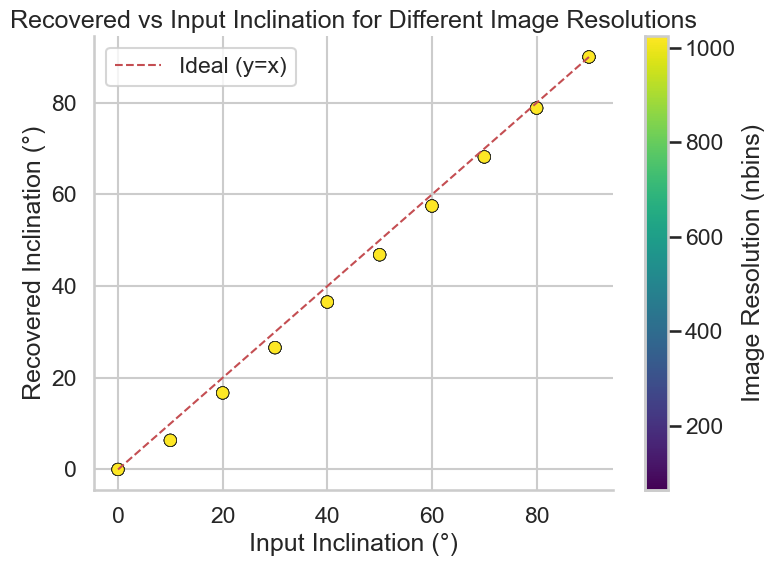

In [55]:
from scipy.optimize import root_scalar

N = 1000000
a = 6              
import seaborn as sns# reconstruction scale as requested

nbins = [2**6, 2**7, 2**8, 2**9, 2**10]


noise = 0.0
mmax, nmax = 6, 10
imgs=[]
re_imgs=[]
Inc_list=[0,10,20,30,40,50,60,70,80,90]
records = []
for nb in nbins:
    for Inc in Inc_list:
        rmax=nb/2
        # generate galaxy
        D = DiscGalaxy(N=N, a=a)
        D.rotate_disc(Inc, 0, 90+70)   # inc=20, PA=45
        D.generate_image(rmax=rmax, nbins=nb, noiselevel=noise)
        img_orig = D.img.copy()
        imgs.append(img_orig)

        # --- Laguerre expansion & reconstruction on the same grid ---
        E1 = D.make_expansion(mmax, nmax, a, noisy=False)
        E1.laguerre_reconstruction(D.r, D.p)
        # Map reconstruction back to the image grid via histogramming
        x_edges = np.linspace(-rmax, rmax, nb + 1)
        y_edges = np.linspace(-rmax, rmax, nb + 1)
        x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
        y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
        X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
        x_flat = X2.ravel()
        y_flat = Y2.ravel()
        w_flat = E1.reconstruction.ravel()
        R,P = np.sqrt(X2**2 + Y2**2), np.arctan2(Y2, X2)
        #L = FLEX(a,mmax,nmax, R.flatten(), P.flatten(), mass=image_data.flatten())
        
        c1 = E1.coscoefs; s1 = E1.sincoefs
    
        num = np.linalg.norm(np.sqrt(E1.coscoefs[2]**2 + E1.sincoefs[2]**2))
        den = np.linalg.norm(E1.coscoefs[0])

        eta_bt     = num/den
        
        A_fit = -1.9953 
        B_fit = -0.6074 
        D_fit = 2.0000 
        E_fit = 0.0005
        F_fit = 0.0795 
        
        def cos_plus_exp(x_deg, A, B, D, E, F):
            x_rad = np.deg2rad(x_deg)
            return A * np.cos(B * x_rad) + D + E * np.exp(F * x_deg)

        def find_inclination_from_eta(eta_target, A, B, D, E, F,
                                  search_range=(0, 90), tol=1e-6, verbose=False):
            def f(x):
                return cos_plus_exp(x, A, B, D, E, F) - eta_target

            x_min, x_max = search_range
            fmin, fmax = f(x_min), f(x_max)
            if np.sign(fmin) == np.sign(fmax):
                if verbose:
                    print("Eta target is outside model range, extrapolating.")
                x_grid = np.linspace(x_min, x_max, 2000)
                return x_grid[np.argmin(np.abs(f(x_grid)))]

            sol = root_scalar(f, bracket=[x_min, x_max], method='brentq', xtol=tol)
            if not sol.converged:
                raise RuntimeError("Root finding failed to converge.")
            return sol.root

        inc_bt=find_inclination_from_eta(eta_bt,A_fit,B_fit,D_fit,E_fit,F_fit)  # produces E1.reconstruction on a point set

        print(f"Inc={inc_bt}, true = {Inc}")

        recon_img, _, _ = np.histogram2d(
            x_flat, y_flat,
            bins=[x_edges, y_edges],
            weights=w_flat
        )
        counts, _, _ = np.histogram2d(
            x_flat, y_flat,
            bins=[x_edges, y_edges]
        )

        # avoid divide-by-zero; normalize total flux to the original image
        recon_img = recon_img / np.maximum(counts, 1)
        # match total intensity
        total_recon = np.sum(recon_img)
        if total_recon > 0:
            recon_img *= np.sum(img_orig) / total_recon

        recon_img = recon_img.T  # to match imshow orientation
        re_imgs.append(recon_img)
        records.append((nb, Inc, inc_bt, eta_bt))

records = np.array(records, dtype=float)
nb_vals, inc_in, inc_out, eta_out = records[:,0], records[:,1], records[:,2], records[:,3]

# set seaborn style
sns.set(style="whitegrid", context="talk")

# create colormap for the different nbins values
cmap = plt.cm.viridis  # choose: 'magma', 'plasma', 'coolwarm', etc.
norm = plt.Normalize(min(nbins), max(nbins))
colors = [cmap(norm(nb)) for nb in nb_vals]

plt.figure(figsize=(8,6))
sc = plt.scatter(inc_in, inc_out, c=nb_vals, cmap=cmap, s=80, edgecolor='k', linewidth=0.5)

# add identity line
plt.plot([0,90], [0,90], 'r--', lw=1.5, label='Ideal (y=x)')

# axis & aesthetics
plt.xlabel("Input Inclination (°)")
plt.ylabel("Recovered Inclination (°)")
plt.title("Recovered vs Input Inclination for Different Image Resolutions")


# colorbar to show nbins scale
cbar = plt.colorbar(sc)
cbar.set_label("Image Resolution (nbins)")

plt.legend(frameon=True)
sns.despine()
plt.tight_layout()
plt.show()


    

In [ ]:
from scipy.optimize import root_scalar

N = 1000000
a = 6              
import seaborn as sns# reconstruction scale as requested

nbins = [2**6, 2**7, 2**8, 2**9, 2**10]


noise = 0.0
mmax, nmax = 6, 10
imgs=[]
re_imgs=[]
Inc_list=[0,10,20,30,40,50,60,70,80,90]
records2 = []
for nb in nbins:
    for Inc in Inc_list:
        rmax=nb/2
        # generate galaxy
        D = DiscGalaxy(N=N, a=a)
        D.rotate_disc(Inc, 0, 90+70)   # inc=20, PA=45
        D.generate_image(rmax=rmax, nbins=nb, noiselevel=noise)
        img_orig = D.img.copy()
        imgs.append(img_orig)

        # --- Laguerre expansion & reconstruction on the same grid ---
        E1 = D.make_expansion(mmax, nmax, a, noisy=False)
        E1.laguerre_reconstruction(D.r, D.p)
        # Map reconstruction back to the image grid via histogramming
        x_edges = np.linspace(-rmax, rmax, nb + 1)
        y_edges = np.linspace(-rmax, rmax, nb + 1)
        x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
        y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
        X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
        x_flat = X2.ravel()
        y_flat = Y2.ravel()
        w_flat = E1.reconstruction.ravel()
        R,P = np.sqrt(X2**2 + Y2**2), np.arctan2(Y2, X2)
        #L = FLEX(a,mmax,nmax, R.flatten(), P.flatten(), mass=image_data.flatten())
        
        c1 = E1.coscoefs; s1 = E1.sincoefs
    
        num = np.linalg.norm(np.sqrt(E1.coscoefs[2]**2 + E1.sincoefs[2]**2))
        den = np.linalg.norm(E1.coscoefs[0])

        eta_bt     = num/den
        
        A_fit = -1.9953 
        B_fit = -0.6074 
        D_fit = 2.0000 
        E_fit = 0.0005
        F_fit = 0.0795 
        
        def cos_plus_exp(x_deg, A, B, D):
            x_rad = np.deg2rad(x_deg)
            return A * np.cos(B * x_rad) + D 

        def find_inclination_from_eta(eta, A, B, D):
                x=1/B*(np.arccos((eta-D)/A))
                inc= -np.rad2deg(x)
                return inc
        
        inc_bt=find_inclination_from_eta(eta_bt,A_fit,B_fit,D_fit)  # produces E1.reconstruction on a point set

        print(f"Inc={inc_bt}, true = {Inc}")

        recon_img, _, _ = np.histogram2d(
            x_flat, y_flat,
            bins=[x_edges, y_edges],
            weights=w_flat
        )
        counts, _, _ = np.histogram2d(
            x_flat, y_flat,
            bins=[x_edges, y_edges]
        )

        # avoid divide-by-zero; normalize total flux to the original image
        recon_img = recon_img / np.maximum(counts, 1)
        # match total intensity
        total_recon = np.sum(recon_img)
        if total_recon > 0:
            recon_img *= np.sum(img_orig) / total_recon

        recon_img = recon_img.T  # to match imshow orientation
        re_imgs.append(recon_img)
        records2.append((nb, Inc, inc_bt, eta_bt))

records2 = np.array(records2, dtype=float)
nb_vals, inc_in, inc_out, eta_out = records2[:,0], records2[:,1], records2[:,2], records2[:,3]

# set seaborn style
sns.set(style="whitegrid", context="talk")

# create colormap for the different nbins values
cmap = plt.cm.viridis  # choose: 'magma', 'plasma', 'coolwarm', etc.
norm = plt.Normalize(min(nbins), max(nbins))
colors = [cmap(norm(nb)) for nb in nb_vals]

plt.figure(figsize=(8,6))
sc = plt.scatter(inc_in, inc_out, c=nb_vals, cmap=cmap, s=80, edgecolor='k', linewidth=0.5)

# add identity line
plt.plot([0,90], [0,90], 'r--', lw=1.5, label='Ideal (y=x)')

# axis & aesthetics
plt.xlabel("Input Inclination (°)")
plt.ylabel("Recovered Inclination (°)")
plt.title("Recovered vs Input Inclination for Different Image Resolutions")


# colorbar to show nbins scale
cbar = plt.colorbar(sc)
cbar.set_label("Image Resolution (nbins)")

plt.legend(frameon=True)
sns.despine()
plt.tight_layout()
plt.show()


    

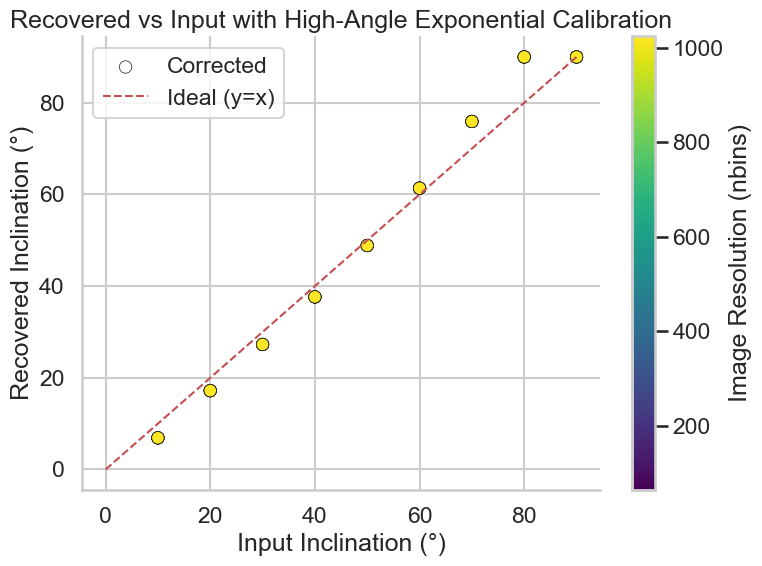

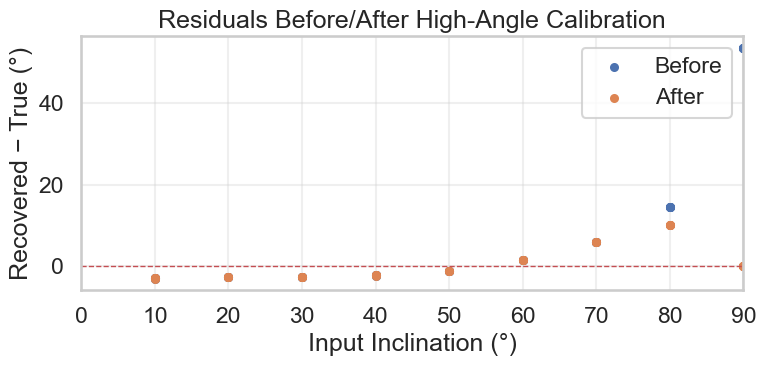

High-angle calibration parameters: [1.22478121e-08 3.24839345e-10]


In [47]:
import numpy as np
from scipy.optimize import curve_fit

# residual model (x in degrees), pinned to 0 at x=60
def resid_model(x, a, b):
    x = np.asarray(x, dtype=float)
    dx = np.maximum(0.0, x - 60.0)
    return a * (1.0 - np.exp(-b * dx))

# prepare data to fit on the high-angle region
mask = inc_out > 60.0
x_fit = inc_out[mask]
y_fit = (inc_in - inc_out)[mask]   # residual = true - recovered

# robust-ish initial guesses and bounds (positive a,b)
p0 = [15.0, 0.1]
bounds = ([0.0, 0.0], [60.0, 5.0])

if len(x_fit) >= 2 and np.any(np.isfinite(y_fit)):
    popt, _ = curve_fit(resid_model, x_fit, y_fit, p0=p0, bounds=bounds, maxfev=100000)
    a_hat, b_hat = popt
else:
    a_hat, b_hat = 0.0, 0.0  # fallback (no correction)

# apply correction piecewise
resid = resid_model(inc_out, a_hat, b_hat)
inc_corr = inc_out + resid
inc_corr = np.clip(inc_corr, 0.0, 90.0)

# --- plot corrected vs input ---
plt.figure(figsize=(8,6))
sc = plt.scatter(inc_in, inc_corr, c=nb_vals, cmap=cmap, s=80, edgecolor='k', linewidth=0.5, label='Corrected')
plt.plot([0,90],[0,90],'r--',lw=1.5,label='Ideal (y=x)')
plt.xlabel("Input Inclination (°)")
plt.ylabel("Recovered Inclination (°)")
plt.title("Recovered vs Input with High-Angle Exponential Calibration")
cbar = plt.colorbar(sc); cbar.set_label("Image Resolution (nbins)")
plt.legend(); sns.despine(); plt.tight_layout(); plt.show()

# (optional) inspect residuals before/after
plt.figure(figsize=(8,4))
plt.scatter(inc_in, inc_out - inc_in, s=25, label='Before')
plt.scatter(inc_in, inc_corr - inc_in, s=25, label='After')
plt.axhline(0, color='r', ls='--', lw=1)
plt.xlim(0,90)
plt.xlabel("Input Inclination (°)")
plt.ylabel("Recovered − True (°)")
plt.title("Residuals Before/After High-Angle Calibration")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

print(f"High-angle calibration parameters: {popt}")

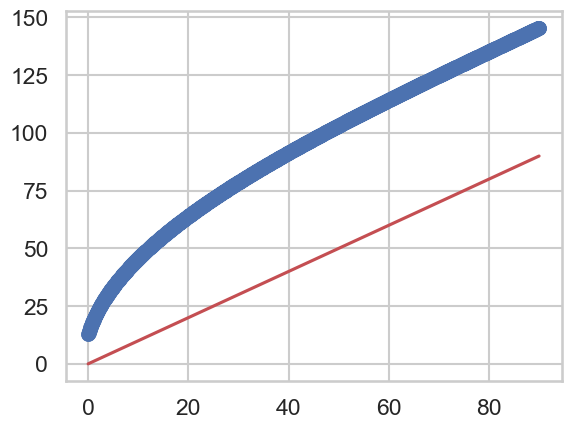

In [29]:
inclist=np.linspace(60,90,2000)
incs=np.linspace(0,90,2000)
eta_avg_list=np.linspace(0,2,2000)
plt.scatter(incs, find_inclination_from_eta(eta_avg_list,A_fit,B_fit,D_fit))
plt.plot(incs,incs, 'r-')


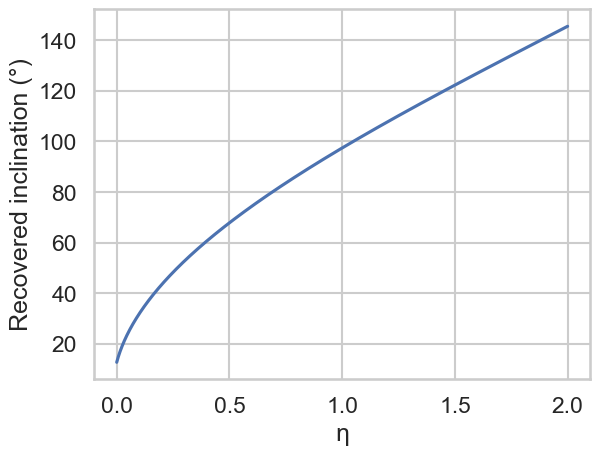

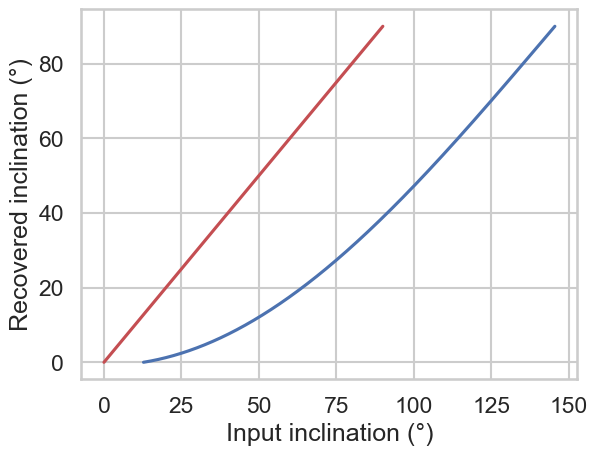

In [51]:
eta = np.linspace(0, 2, 2000)
inc_pred = find_inclination_from_eta(eta, A_fit, B_fit, D_fit)
incs=np.linspace(0,90,2000)
plt.plot(eta, inc_pred)
plt.xlabel("η"); plt.ylabel("Recovered inclination (°)")
plt.show()
plt.plot(inc_pred,incs)
plt.plot(incs,incs, 'r-')
plt.xlabel("Input inclination (°)"); plt.ylabel("Recovered inclination (°)")
plt.show()



In [56]:
from flex import FLEX
from scipy.stats import linregress
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from scipy.optimize import root_scalar

def galaxymorphology(file, galaxy=None, data=None, noisefloor=-5.):
    """
    Returns:
        inc_corr  : corrected inclination (deg, in [0,90])
        PA_deg    : position angle estimate (deg)
        galaxy_id : name parsed from filename prefix (before first '-')
        a_used    : Laguerre 'a' scale used
        eta_bt    : measured eta = ||m=2|| / ||m=0||
        maxrad    : fitted radial cutoff used for profile
        radius    : initial circular mask radius
    """

    # --------- HARD-CODED HIGH-ANGLE RESIDUAL (edit if you recalibrate) ----------
    # r(x) = a_hat * (1 - exp(-b_hat * (x - 60)_+))
    a_hat = 1.22478121e-08   # <-- your fitted 'a' (global)
    b_hat = 3.24839345e-10   # <-- your fitted 'b' (global)
    # ------------------------------------------------------------------------------

    # Forward model (degrees)
    def cos_plus_exp(x_deg, A, B, D, E, F):
        x_rad = np.deg2rad(x_deg)
        return A * np.cos(B * x_rad) + D + E * np.exp(F * x_deg)

    # Robust inverse on [0,90] with clamping to reachable eta-range
    def invert_eta_to_incl(eta_target, A, B, D, E, F, lo=0.0, hi=90.0, xtol=1e-6):
        # clamp tiny overshoots into achievable range
        e_lo = cos_plus_exp(lo, A, B, D, E, F)
        e_hi = cos_plus_exp(hi, A, B, D, E, F)
        e_min, e_max = (e_lo, e_hi) if e_lo <= e_hi else (e_hi, e_lo)
        eta = float(np.clip(eta_target, e_min, e_max))

        f = lambda x: cos_plus_exp(x, A, B, D, E, F) - eta
        flo, fhi = f(lo), f(hi)
        if np.sign(flo) == np.sign(fhi):
            # fallback: choose boundary with smaller |f|
            return lo if abs(flo) < abs(fhi) else hi

        sol = root_scalar(f, bracket=[lo, hi], method='brentq', xtol=xtol)
        return sol.root if sol.converged else np.nan

    # Residual correction (deg → deg), pinned to 0 at 60°
    def high_angle_residual(x_deg, a=a_hat, b=b_hat):
        dx = np.maximum(0.0, x_deg - 60.0)
        return a * (1.0 - np.exp(-b * dx))

    # --------------------- Load image & (optional) WCS ---------------------
    with fits.open(file) as hdulist:
        image_data = hdulist[1].data  # adapt if your FITS structure differs
        if data is not None:
            if galaxy is None:
                raise ValueError("If 'data' is provided, 'galaxy' must also be defined.")
            ra = data['RA_LEDA'][data['GALAXY'] == galaxy]
            dec = data['DEC_LEDA'][data['GALAXY'] == galaxy]
            wcs = WCS(hdulist[1].header)
            px, py = wcs.world_to_pixel_values(ra, dec)  # arrays
            cx, cy = float(px[0]), float(py[0])
        else:
            h, w = image_data.shape
            cx, cy = (w // 2), (h // 2)

    galaxy_name = file.split("-")[0]
    h, w = image_data.shape

    # ------------------------ Circular mask / crop -------------------------
    radius = h // 4  # hyperparameter
    y, x = np.indices((h, w))
    mask = (x - cx) ** 2 + (y - cy) ** 2 <= radius ** 2
    gray = np.where(mask, image_data, 0.0)

    # Centered coordinates (fixing axis swap)
    X2 = x - cx
    Y2 = y - cy

    # ----------------------- Radial profile for 'a' ------------------------
    R = np.sqrt(X2 ** 2 + Y2 ** 2).ravel()
    I = image_data.ravel()

    valid = (I > 0) & (R <= radius)
    R_valid = R[valid]
    I_valid = I[valid]

    # Moving-average for noise cut (simple)
    rindx = R_valid.argsort()
    R_sorted = R_valid[rindx]
    I_sorted = I_valid[rindx]

    window = 100  # hyperparameter
    if len(R_sorted) >= window:
        means_R = np.convolve(R_sorted, np.ones(window) / window, mode='valid')
        means_I = np.convolve(I_sorted, np.ones(window) / window, mode='valid')
    else:
        means_R, means_I = R_sorted, I_sorted

    idx_noise = np.where(np.log(np.clip(means_I, 1e-12, None)) < noisefloor)[0]
    maxrad = means_R[idx_noise[0]] if idx_noise.size > 0 else means_R[-1]

    valid = (I > 0) & (R <= maxrad)
    R_valid = R[valid]
    logI_valid = np.log(I[valid])

    slope, intercept, *_ = linregress(R_valid, logI_valid)
    scale_length = -1 / slope if slope != 0 else 50.0
    scale_length = 50.0 if scale_length < 0 else scale_length
    scale_length = 30.0 if scale_length > 100 else scale_length

    a = 1.5 * scale_length  # Laguerre scale

    # --------------------- Laguerre expansion (FLEX) -----------------------
    mmax, nmax = 8, 10
    R_img = np.sqrt(X2 ** 2 + Y2 ** 2)
    P_img = np.arctan2(Y2, X2)

    L = FLEX(a, mmax, nmax, R_img.flatten(), P_img.flatten(), mass=image_data.flatten())
    c1 = L.coscoefs
    s1 = L.sincoefs

    # eta = ||m=2|| / ||m=0||
    num = np.linalg.norm(np.sqrt(L.coscoefs[2] ** 2 + L.sincoefs[2] ** 2))
    den = np.linalg.norm(L.coscoefs[0])
    eta_bt = num / den if den != 0 else np.nan

    # ------------------ Model parameters (your current fit) ----------------
    A_fit = -1.9953
    B_fit = -0.6074
    D_fit =  2.0000
    E_fit =  0.0005
    F_fit =  0.0795

    # ----------------------- Invert to inclination -------------------------
    inc_bt = invert_eta_to_incl(eta_bt, A_fit, B_fit, D_fit, E_fit, F_fit, lo=0.0, hi=90.0)

    # ------------------- Apply high-angle residual (hard-coded) ------------
    if np.isfinite(inc_bt):
        inc_bt = inc_bt + high_angle_residual(inc_bt, a_hat, b_hat)
        inc_bt = float(np.clip(inc_bt, 0.0, 90.0))

    # ------------------- Position angle from phase (m=2) -------------------
    phi = np.arctan2(s1[2, 0], c1[2, 0])  # radians
    # map to your PA convention
    if phi < 0:
        phi = -np.pi - phi
    else:
        phi = np.pi - phi
    PA_deg = 90.0 + 0.5 * np.degrees(phi)

    return inc_bt, PA_deg, galaxy_name, a, eta_bt, maxrad, radius


In [53]:
Name=[]
Inc=[]
PA=[]
eta=[]
fits_files = glob.glob('data/gfits3/*.fits.fz')
for idx, file in enumerate(fits_files):
    A=galaxymorphology(fits_files[idx])
    Name.append(A[2])
    Inc.append(A[0])
    PA.append(A[1])
    eta.append(A[4])
    print(f"Processed {A[2]}: Inc={A[0]:.2f}, PA={A[1]:.2f}, eta={A[4]:.4f}")

Processed data/gfits3/NGC5289: Inc=51.40, PA=171.06, eta=0.3235
Processed data/gfits3/NGC6186: Inc=55.98, PA=32.32, eta=0.3886
Processed data/gfits3/NGC3310: Inc=32.38, PA=84.83, eta=0.1277
Processed data/gfits3/NGC2893: Inc=36.95, PA=111.52, eta=0.1653
Processed data/gfits3/NGC2776: Inc=44.83, PA=140.71, eta=0.2434
Processed data/gfits3/NGC4203: Inc=80.72, PA=85.51, eta=0.9981
Processed data/gfits3/NGC5676: Inc=61.55, PA=47.98, eta=0.4813
Processed data/gfits3/NGC4369: Inc=57.14, PA=122.40, eta=0.4066
Processed data/gfits3/NGC4100: Inc=83.69, PA=106.26, eta=1.1274
Processed data/gfits3/NGC5112: Inc=63.31, PA=143.03, eta=0.5142
Processed data/gfits3/NGC3726: Inc=55.80, PA=68.12, eta=0.3860
Processed data/gfits3/NGC4359: Inc=74.58, PA=160.24, eta=0.7844
Processed data/gfits3/NGC3556: Inc=79.37, PA=10.34, eta=0.9452
Processed data/gfits3/NGC6217: Inc=41.24, PA=118.61, eta=0.2056
Processed data/gfits3/NGC3403: Inc=81.22, PA=15.47, eta=1.0183
Processed data/gfits3/NGC6140: Inc=78.83, PA=27

KeyboardInterrupt: 

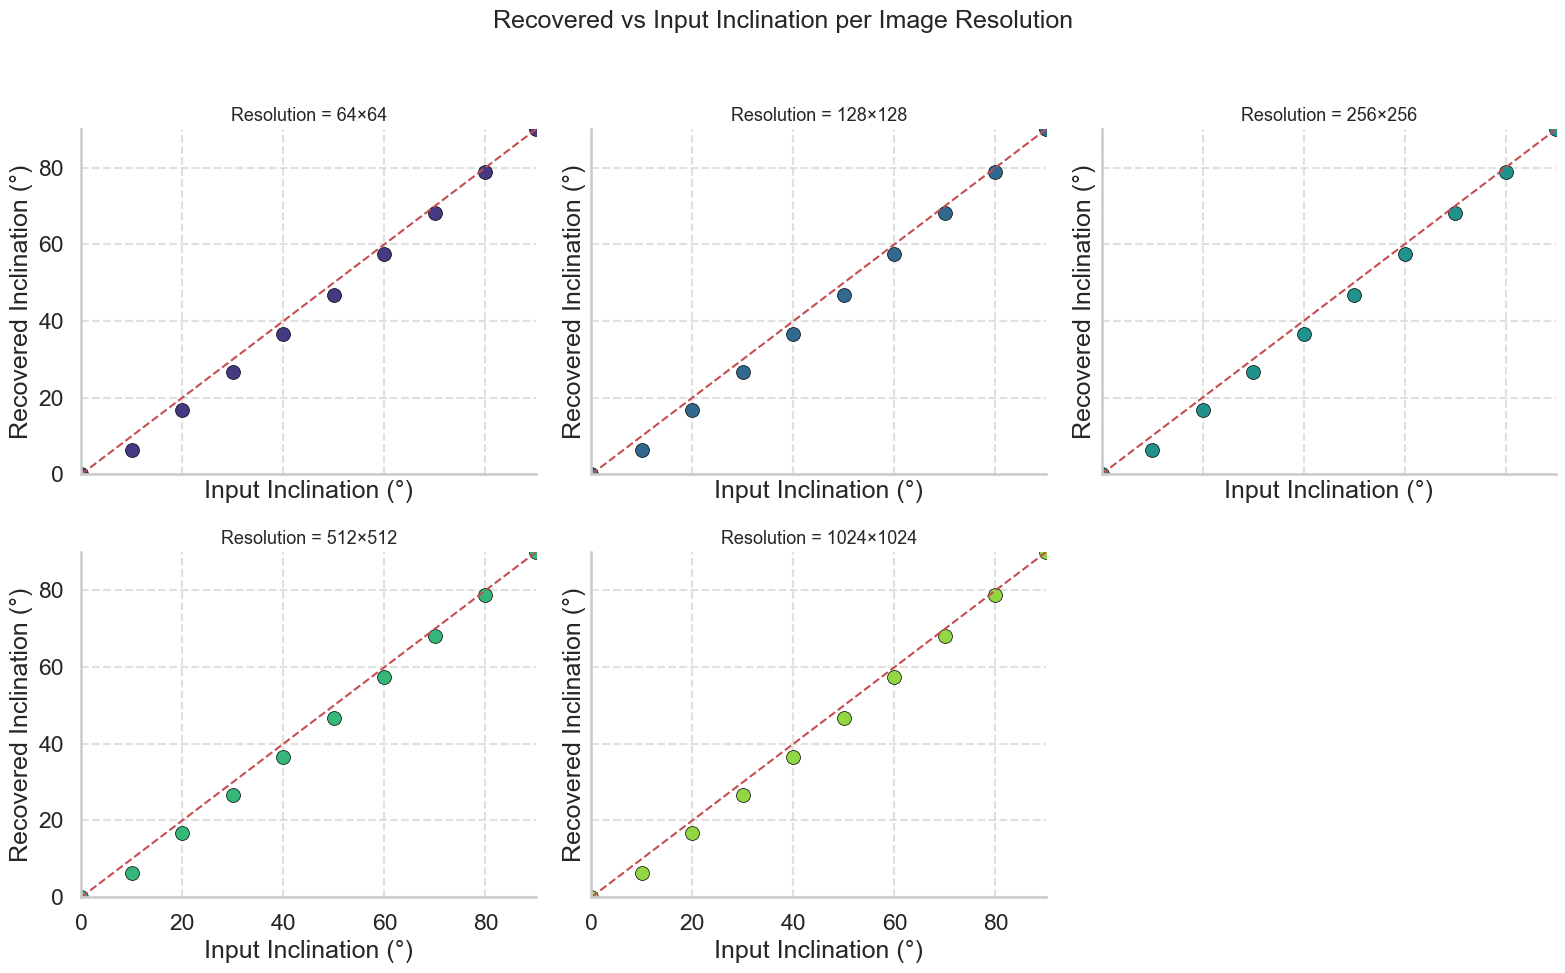

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert stored results to NumPy array if you haven't yet
records = np.array(records, dtype=float)
nb_vals, inc_in, inc_out = records[:, 0], records[:, 1], records[:, 2]


# Seaborn aesthetic
sns.set(style="whitegrid", context="talk")

# Unique resolution values (sorted ascending)
unique_nbins = sorted(set(nb_vals))

# Create subplots: one per resolution
ncols = 3
nrows = int(np.ceil(len(unique_nbins) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, nb in enumerate(unique_nbins):
    ax = axes[i]
    sel = nb_vals == nb

    ax.scatter(
        inc_in[sel], inc_out[sel],
        s=100, edgecolor='black', linewidth=0.5,
        color=sns.color_palette("viridis", len(unique_nbins))[i]
    )

    # Ideal reference line
    ax.plot([0, 90], [0, 90], 'r--', lw=1.5)

    ax.set_title(f"Resolution = {int(nb)}×{int(nb)}", fontsize=13)
    ax.set_xlim(0, 90)
    ax.set_ylim(0, 90)
    ax.set_xlabel("Input Inclination (°)")
    
    ax.set_ylabel("Recovered Inclination (°)")
    ax.grid(True, linestyle="--", alpha=0.6)

# Remove any unused subplots if grid > number of resolutions
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Recovered vs Input Inclination per Image Resolution", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
sns.despine()

plt.show()


In [91]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from scipy.stats import linregress
from scipy.optimize import root_scalar
from flex import FLEX

# requires: from flex import FLEX

def galaxymorphology(file_or_array, galaxy=None, data=None, noisefloor=-5.0):
    """
    Compute inclination and position angle from a galaxy image.

    Parameters
    ----------
    file_or_array : str | np.ndarray
        Either a FITS filename (string path) or a 2D NumPy array image.
        If FITS: image is read from HDU[1] if present, else HDU[0].
    galaxy : str, optional
        Galaxy name (used only if 'data' with RA/DEC is provided).
    data : pandas.DataFrame or dict-like, optional
        Must contain RA/DEC columns (e.g. 'RA_LEDA', 'DEC_LEDA') and 'GALAXY'.
        If provided (with galaxy), recenters using WCS pixel coordinates.
    noisefloor : float, default -5.0
        Log-intensity threshold for outer radius selection.

    Returns
    -------
    inc_bt : float
        Estimated inclination (degrees).
    PA : float
        Estimated position angle (degrees, astronomical convention).
    galaxy_name : str
        Galaxy identifier (or "synthetic" for arrays).
    a : float
        Scale parameter used for FLEX (1.5 * exponential scale length).
    eta_bt : float
        Bulge-to-total-like estimator from m=2 amplitude ratio.
    maxrad : float
        Outer radius (pixels) determined by noise floor.
    radius : float
        Working aperture radius (pixels) used for initial masking.
    """
    # --- Helpers --------------------------------------------------------------
    def cos_plus_exp(x_deg, A, B, D,C, E, F):
        x_rad = np.deg2rad(x_deg)
        return A * np.cos(B * x_rad+C) + D + E * np.exp(F * x_deg)

    def find_inclination_from_eta(eta_target, A, B, D, C, E, F,
                                  search_range=(0, 90), tol=1e-6, verbose=False):
        def f(x):
            return cos_plus_exp(x, A, B, C,D, E, F) - eta_target

        x_min, x_max = search_range
        fmin, fmax = f(x_min), f(x_max)
        if np.sign(fmin) == np.sign(fmax):
            if verbose:
                print("Eta target is outside model range, extrapolating.")
            x_grid = np.linspace(x_min, x_max, 2000)
            return x_grid[np.argmin(np.abs(f(x_grid)))]

        sol = root_scalar(f, bracket=[x_min, x_max], method='brentq', xtol=tol)
        if not sol.converged:
            raise RuntimeError("Root finding failed to converge.")
        return sol.root

    # --- Input handling: array OR FITS ---------------------------------------
    if isinstance(file_or_array, np.ndarray):
        image_data = np.asarray(file_or_array, dtype=float)
        header = None
        wcs = None
        galaxy_name = "synthetic"
    else:
        # FITS path
        with fits.open(file_or_array) as hdulist:
            if len(hdulist) > 1 and hdulist[1].data is not None:
                image_data = np.asarray(hdulist[1].data, dtype=float)
                header = hdulist[1].header
            else:
                image_data = np.asarray(hdulist[0].data, dtype=float)
                header = hdulist[0].header
        galaxy_name = str(file_or_array).split("-")[0]
        try:
            wcs = WCS(header)
        except Exception:
            wcs = None

    # --- Basic geometry -------------------------------------------------------
    if image_data.ndim != 2:
        raise ValueError("Input image must be a 2D array.")

    h, w = image_data.shape
    y, x = np.indices((h, w))  # y=row, x=col

    # Working aperture (adjustable hyperparameter)
    radius = h // 4

    # Centering: WCS if galaxy/data provided; else image center
    if (data is not None) and (galaxy is not None) and (wcs is not None):
        ra = data['RA_LEDA'][data['GALAXY'] == galaxy]
        dec = data['DEC_LEDA'][data['GALAXY'] == galaxy]
        pix = wcs.world_to_pixel_values(ra, dec)
        cx, cy = float(pix[0]), float(pix[1])
    else:
        cx, cy = (w // 2), (h // 2)

    # Shifted coordinates (X along columns, Y along rows)
    X = x - cx
    Y = y - cy
    R = np.sqrt(X**2 + Y**2)

    # --- Initial circular mask to suppress outskirts -------------------------
    mask = R <= radius
    work = np.where(mask, image_data, 0.0)

    # --- Select radial profile points with positive flux ----------------------
    I = image_data.ravel()  # use original for slope, but restrict by radius later
    R_flat = R.ravel()
    valid0 = (I > 0) & (R_flat <= radius)
    R_valid = R_flat[valid0]
    I_valid = I[valid0]

    # Sort by radius
    rindx = R_valid.argsort()
    R_sorted = R_valid[rindx]
    I_sorted = I_valid[rindx]

    # Moving average for noise floor detection
    window = min(100, max(5, len(R_sorted)//50))  # adaptive, keeps it robust
    if window % 2 == 0:
        window += 1
    if len(R_sorted) < window:
        window = max(5, len(R_sorted))

    if window <= 1:
        means_R = R_sorted
        means_I = I_sorted
    else:
        kern = np.ones(window) / window
        means_R = np.convolve(R_sorted, kern, mode='valid')
        means_I = np.convolve(I_sorted, kern, mode='valid')

    # Determine outer radius by noise floor in log-space
    I_clip = np.clip(means_I, 1e-12, None)
    below = np.where(np.log(I_clip) < noisefloor)[0]
    maxrad = float(means_R[below[0]]) if len(below) > 0 else float(means_R[-1])

    # --- Fit exponential scale length in ln I vs R within maxrad -------------
    sel = (R_flat <= maxrad) & (image_data.ravel() > 0)
    R_fit = R_flat[sel]
    lnI_fit = np.log(np.clip(image_data.ravel()[sel], 1e-12, None))

    if len(R_fit) < 10:
        # Fallback if too few points
        scale_length = 30.0
    else:
        slope, intercept, *_ = linregress(R_fit, lnI_fit)
        scale_length = -1.0 / slope if slope != 0 else 30.0
        # Clamp to plausible range
        if scale_length < 0:
            scale_length = 50.0
        if scale_length > 100:
            scale_length = 30.0

    a = 1.5 * float(scale_length)

    # --- Laguerre / FLEX expansion ------------------------------------------
    mmax, nmax = 8, 10
    # R, P in polar coordinates over entire image (not only masked)
    P = np.arctan2(Y, X)

    L = FLEX(a, mmax, nmax, R.ravel(), P.ravel(), mass=image_data.ravel())
    c1, s1 = L.coscoefs, L.sincoefs  # shapes: (mmax+1, nmax+1) each

    # m=2 amplitude normalized by m=0 gives eta-like quantity
    num = np.linalg.norm(np.sqrt(c1[2]**2 + s1[2]**2))
    den = np.linalg.norm(c1[0])

    eta_bt = num / den 
    # --- Map eta -> inclination (fit model coefficients, from your code) -----
    if h==64:
        A_fit=-1.49622942e-01
        B_fit=-3.25013042  
        C_fit=8.82095893
        D_fit=-9.99999753e-01
        E_fit=1.01878444 
        F_fit=7.78671084e-03
    if h==128:
        A_fit=-0.28589325 
        B_fit=-1.9746376   
        C_fit=8.50704234 
        D_fit=-0.92001011  
        E_fit=0.89375603  
        F_fit=0.01039217
    if h==256:
        A_fit=-0.24444315 
        B_fit=-2.27534356  
        C_fit=8.59288841 
        D_fit=-0.99999985  
        E_fit=0.94045508  
        F_fit=0.00969384
        
        
    if h>256:
        A_fit=-0.24293078 
        B_fit=-2.27490232  
        C_fit=8.59360551 
        D_fit=-0.99999984  
        E_fit=0.93814061  
        F_fit=0.00971964
    inc_bt = float(
        find_inclination_from_eta(
            eta_bt, A_fit, B_fit, C_fit, D_fit, E_fit, F_fit, verbose=False
        )
    )

    # --- Position Angle from the phase of m=2, n=0 ---------------------------
    phi = np.arctan2(s1[2, 0], c1[2, 0])  # radians
    # Match your original transformation
    if phi < 0:
        phi = -np.pi - phi
    else:
        phi = np.pi - phi
    PA = 90.0 + (np.degrees(phi)) / 2.0

    return float(inc_bt), float(PA), str(galaxy_name), float(a), float(eta_bt), float(maxrad), float(radius)


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- your galaxy generator params ---
N = 100_000        # use 1_000_000 later
a = 6
nbins = [2**6, 2**7, 2**8, 2**9, 2**10]
Inc_list = [0,10,20,30,40,50,60,70,80,90]
PA_in_fixed = 90 + 70         # match your earlier choice
noise = 0.0
mmax, nmax = 6, 10

results = []   # will hold dicts

for nb in nbins:
    rmax = nb/2
    for Inc_in in Inc_list:
        # --- generate synthetic galaxy ---
        D = DiscGalaxy(N=N, a=a)
        D.rotate_disc(Inc_in, 0, PA_in_fixed)   # (inc, ???, PA)
        D.generate_image(rmax=rmax, nbins=nb, noiselevel=noise)
        img = D.img.copy()

        # --- run your morphology extractor on the numpy image ---
        inc_gm, pa_gm, gname, a_used, eta_bt, maxrad, radius = galaxymorphology(img)

        # store
        results.append({
            "nbins": nb,
            "Inc_in": Inc_in,
            "PA_in": PA_in_fixed,
            "Inc_gm": inc_gm,
            "PA_gm": pa_gm,
            "eta_bt": eta_bt,
            "a_used": a_used,
            "maxrad": maxrad,
            "aperture_radius": radius
        })

df = pd.DataFrame(results)
df.head()


,nbins,Inc_in,PA_in,Inc_gm,PA_gm,eta_bt,a_used,maxrad,aperture_radius
0,64,0,160,1.605156,172.952942,0.146529,8.983633,15.861685,16.0
1,64,10,160,3.600869,2.827524,0.151127,8.895416,15.861685,16.0
2,64,20,160,15.560627,11.399077,0.162614,8.721702,15.861685,16.0
3,64,30,160,32.106501,14.999619,0.195320,8.353333,15.861685,16.0
4,64,40,160,40.991711,16.450538,0.255604,7.775147,15.861685,16.0


In [87]:
Name=[]
Inc=[]
PA=[]
eta=[]
fits_files = glob.glob('data/gfits3/*.fits.fz')
for idx, file in enumerate(fits_files):
    A=galaxymorphology(fits_files[idx])
    Name.append(A[2])
    Inc.append(A[0])
    PA.append(A[1])
    eta.append(A[4])
    print(f"Processed {A[2]}: Inc={A[0]:.2f}, PA={A[1]:.2f}, eta={A[4]:.4f}")

Processed data/gfits3/NGC5289: Inc=52.32, PA=171.06, eta=0.3236
Processed data/gfits3/NGC6186: Inc=56.92, PA=32.32, eta=0.3886
Processed data/gfits3/NGC3310: Inc=20.97, PA=84.83, eta=0.1277
Processed data/gfits3/NGC2893: Inc=33.78, PA=111.52, eta=0.1653
Processed data/gfits3/NGC2776: Inc=45.10, PA=140.71, eta=0.2434
Processed data/gfits3/NGC4203: Inc=84.06, PA=85.51, eta=0.9981
Processed data/gfits3/NGC5676: Inc=62.47, PA=47.97, eta=0.4824
Processed data/gfits3/NGC4369: Inc=58.06, PA=122.40, eta=0.4066
Processed data/gfits3/NGC4100: Inc=88.41, PA=106.26, eta=1.1274
Processed data/gfits3/NGC5112: Inc=64.16, PA=143.03, eta=0.5142
Processed data/gfits3/NGC3726: Inc=56.75, PA=68.12, eta=0.3860
Processed data/gfits3/NGC4359: Inc=76.21, PA=160.24, eta=0.7844
Processed data/gfits3/NGC3556: Inc=82.20, PA=10.34, eta=0.9452
Processed data/gfits3/NGC6217: Inc=40.55, PA=118.61, eta=0.2056
Processed data/gfits3/NGC3403: Inc=84.76, PA=15.47, eta=1.0183
Processed data/gfits3/NGC6140: Inc=81.49, PA=27

In [60]:
import pandas as pd

# Assuming `records` is an (N, 4) NumPy array
nb_vals, inc_in, inc_out, eta_out = records[:,0], records[:,1], records[:,2], records[:,3]

# Create a pandas table
table = pd.DataFrame({
    "nb_vals": nb_vals,
    "inc_in": inc_in,
    "inc_out": inc_out,
    "eta_out": eta_out
})

# Display neatly
print(table)

    nb_vals  inc_in    inc_out   eta_out
0      64.0     0.0   0.000000  0.003953
1      64.0    10.0   6.334080  0.010024
2      64.0    20.0  16.682463  0.037706
3      64.0    30.0  26.564682  0.087431
4      64.0    40.0  36.514330  0.161445
5      64.0    50.0  46.837487  0.266357
6      64.0    60.0  57.484651  0.412147
7      64.0    70.0  68.191499  0.616831
8      64.0    80.0  78.841867  0.925694
9      64.0    90.0  90.000000  1.905066
10    128.0     0.0   0.000000  0.003950
11    128.0    10.0   6.351169  0.010049
12    128.0    20.0  16.702571  0.037784
13    128.0    30.0  26.583268  0.087547
14    128.0    40.0  36.529120  0.161574
15    128.0    50.0  46.846447  0.266462
16    128.0    60.0  57.488766  0.412212
17    128.0    70.0  68.193015  0.616866
18    128.0    80.0  78.842178  0.925705
19    128.0    90.0  90.000000  1.905054
20    256.0     0.0   0.000000  0.003950
21    256.0    10.0   6.351200  0.010049
22    256.0    20.0  16.702583  0.037784
23    256.0    3

In [73]:
def mae(x): return np.mean(np.abs(x))
def rmse(x): return np.sqrt(np.mean(x**2))

df["Inc_err"] = df["Inc_gm"] - df["Inc_in"]
df["PA_err"]  = (df["PA_gm"] - df["PA_in"] + 180) % 360 - 180  # wrap PA error to [-180,180]

summary = (
    df.groupby("nbins")
      .apply(lambda g: pd.Series({
          "Inclination_MAE": mae(g["Inc_err"]),
          "Inclination_RMSE": rmse(g["Inc_err"]),
          "PA_MAE": mae(g["PA_err"]),
          "PA_RMSE": rmse(g["PA_err"])
      }))
      .reset_index()
      .sort_values("nbins")
)
print(summary.to_string(index=False))


 nbins  Inclination_MAE  Inclination_RMSE     PA_MAE    PA_RMSE
    64        10.887561         15.257821 131.662770 137.561021
   128        10.458730         15.388175 131.419958 137.297404
   256         8.031286         12.316101 130.710394 136.671215
   512         7.907582         12.111233 130.680265 136.648878
  1024         7.907582         12.111233 130.680265 136.648878


/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_5641/4062674896.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


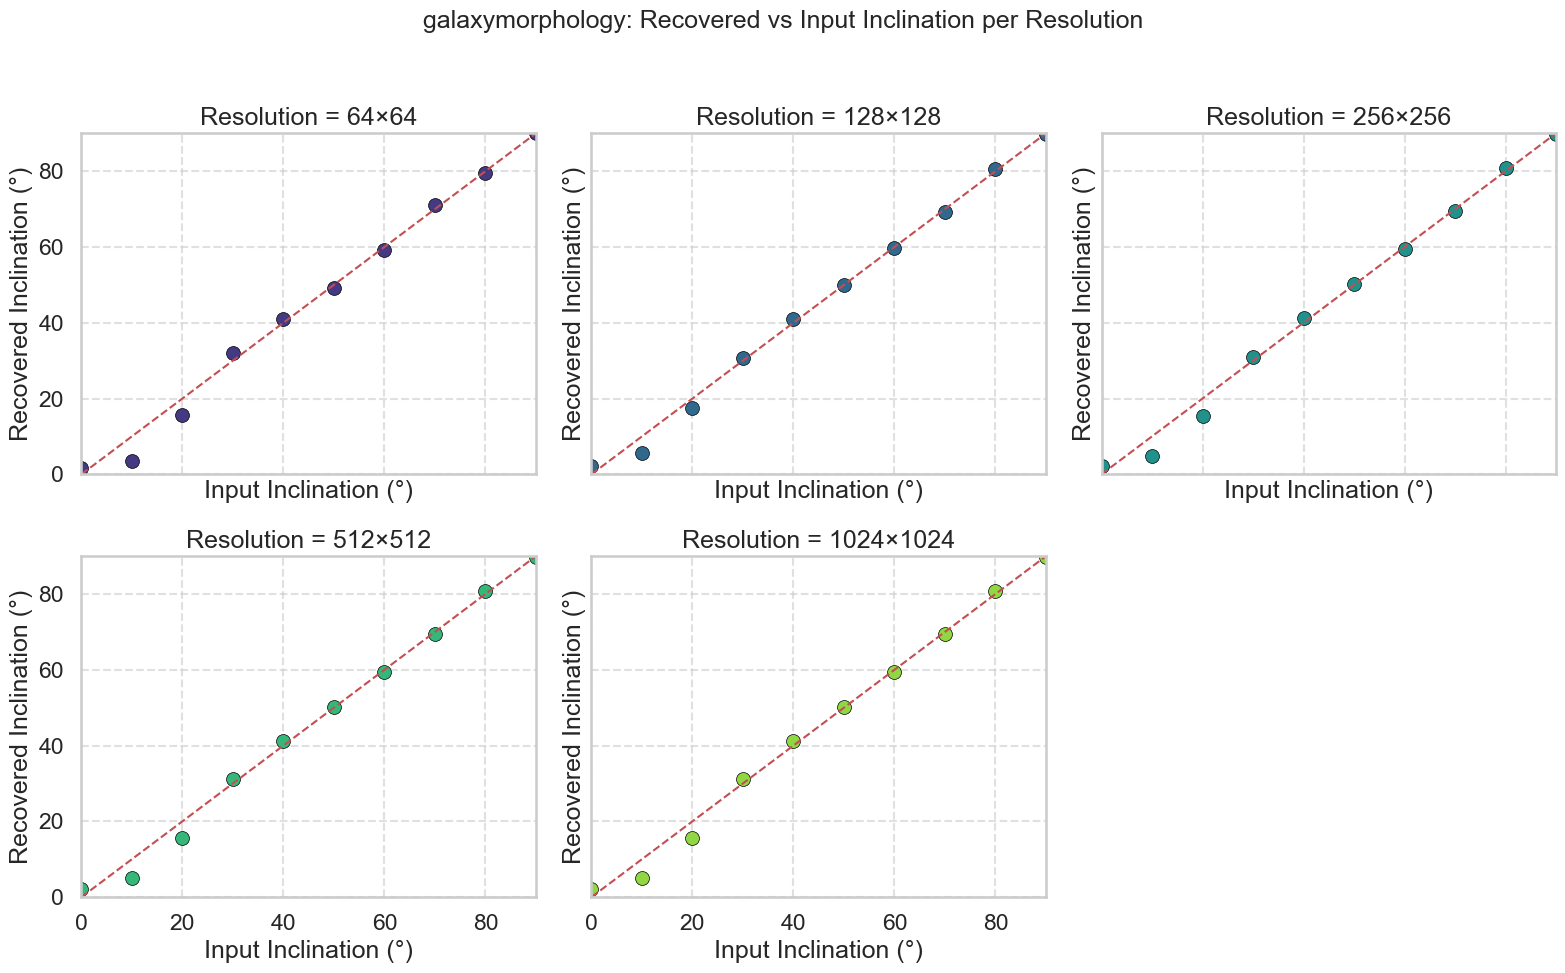

In [93]:
sns.set(style="whitegrid", context="talk")

unique_nbins = sorted(df["nbins"].unique())
ncols = 3
nrows = int(np.ceil(len(unique_nbins)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, nb in enumerate(unique_nbins):
    ax = axes[i]
    g = df[df["nbins"] == nb]
    ax.scatter(g["Inc_in"], g["Inc_gm"], s=100, edgecolor='black', linewidth=0.5,
               color=sns.color_palette("viridis", len(unique_nbins))[i])
    # ideal line
    ax.plot([0,90],[0,90],'r--',lw=1.5)
    ax.set_title(f"Resolution = {int(nb)}×{int(nb)}")
    ax.set_xlim(0,90); ax.set_ylim(0,90)
    ax.set_xlabel("Input Inclination (°)")
    ax.set_ylabel("Recovered Inclination (°)")
    ax.grid(True, linestyle="--", alpha=0.6)

# remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("galaxymorphology: Recovered vs Input Inclination per Resolution", fontsize=18)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()




calibration parameters: [-1.49622942e-01 -3.25013042e+00  8.82095893e+00 -9.99999753e-01
  1.01878444e+00  7.78671084e-03]
calibration parameters: [-0.28589325 -1.9746376   8.50704234 -0.92001011  0.89375603  0.01039217]
calibration parameters: [-0.24444315 -2.27534356  8.59288841 -0.99999985  0.94045508  0.00969384]
calibration parameters: [-0.24293081 -2.27490215  8.59360543 -0.99999984  0.93814061  0.00971964]
calibration parameters: [-0.24293078 -2.27490232  8.59360551 -0.99999984  0.93814061  0.00971964]


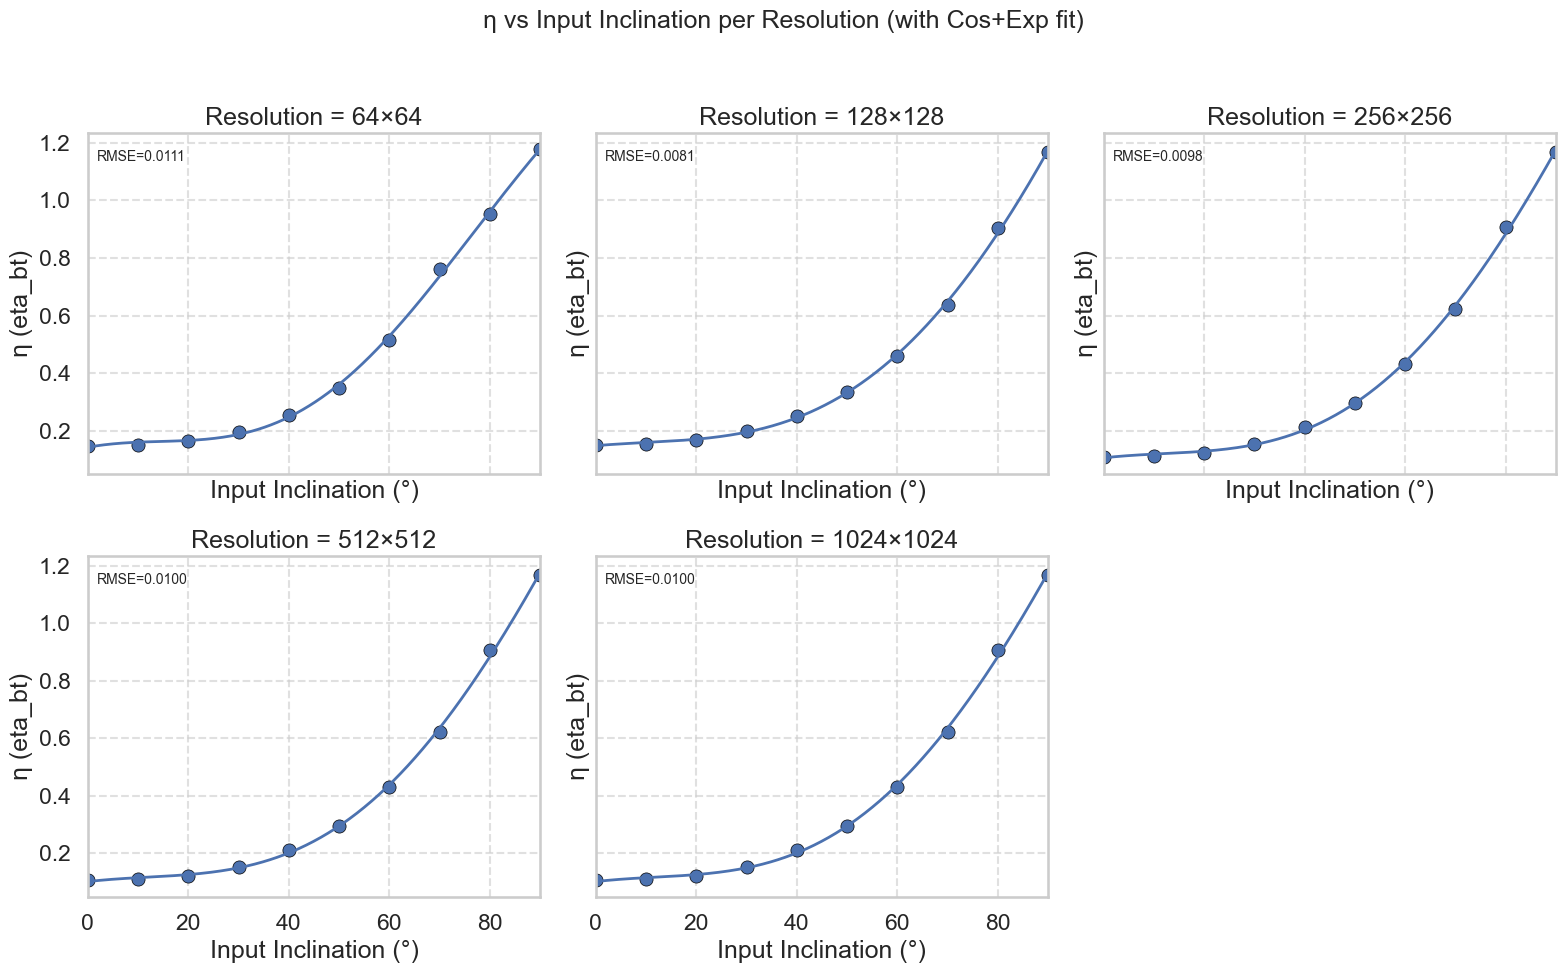

calibration parameters: [-0.24293078 -2.27490232  8.59360551 -0.99999984  0.93814061  0.00971964]


In [84]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

sns.set(style="whitegrid", context="talk")

def cos_plus_exp(x_deg, A, B, C, D, E, F):
    # A * cos(B * radians(x) + C) + D + E * exp(F * x)
    x_rad = np.deg2rad(x_deg)
    return A * np.cos(B * x_rad + C) + D + E * np.exp(F * x_deg)

unique_nbins = sorted(df["nbins"].unique())
ncols = 3
nrows = int(np.ceil(len(unique_nbins) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, nb in enumerate(unique_nbins):
    ax = axes[i]

    # Filter this resolution
    g = df[df["nbins"] == nb].copy()

    # If you have multiple runs per inclination, average them so x/y align 1:1
    g = (g.groupby("Inc_in", as_index=False)
           .agg(eta_bt=("eta_bt", "mean"))     # average eta if repeated
           .sort_values("Inc_in"))

    xdata = g["Inc_in"].to_numpy()             # now same length as ydata
    ydata = g["eta_bt"].to_numpy()

    # Initial guesses / bounds (keep p0 within bounds)
    p0    = [-0.3, -1.65,  6.43, 0.32, 0.01, 0.05]
    lower = [-2.0, -10.0, -10.0, -1.0, -10.0, -1.0]
    upper = [ 2.0,  10.0,  10.0,  2.0,  10.0,  1.0]

    # Fit; if it fails, skip gracefully
    try:
        params, covariance = curve_fit(
            cos_plus_exp, xdata, ydata,
            p0=p0, bounds=(lower, upper), maxfev=100_000
        )
        A_fit, B_fit, C_fit, D_fit, E_fit, F_fit = params
        # Plot fit on the SAME axis
        inc_fit = np.linspace(0, 90, 500)
        eta_fit = cos_plus_exp(inc_fit, *params)
        ax.plot(inc_fit, eta_fit, linewidth=2, label="Fit")
        # Diagnostics (optional)
        residuals = ydata - cos_plus_exp(xdata, *params)
        rmse = float(np.sqrt(np.mean(residuals**2)))
        ax.text(0.02, 0.95, f"RMSE={rmse:.4f}", transform=ax.transAxes,
                va="top", ha="left", fontsize=10)
    except Exception as e:
        ax.text(0.02, 0.95, f"Fit failed:\n{e}", transform=ax.transAxes,
                va="top", ha="left", fontsize=10, color="crimson")

    # Scatter the data
    ax.scatter(xdata, ydata, s=90, edgecolor='black', linewidth=0.5)

    ax.set_title(f"Resolution = {int(nb)}×{int(nb)}")
    ax.set_xlim(0, 90)
    ax.set_xlabel("Input Inclination (°)")
    ax.set_ylabel("η (eta_bt)")
    ax.grid(True, linestyle="--", alpha=0.6)
    print(f"calibration parameters: {params}")

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("η vs Input Inclination per Resolution (with Cos+Exp fit)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
print(f"calibration parameters: {params}")


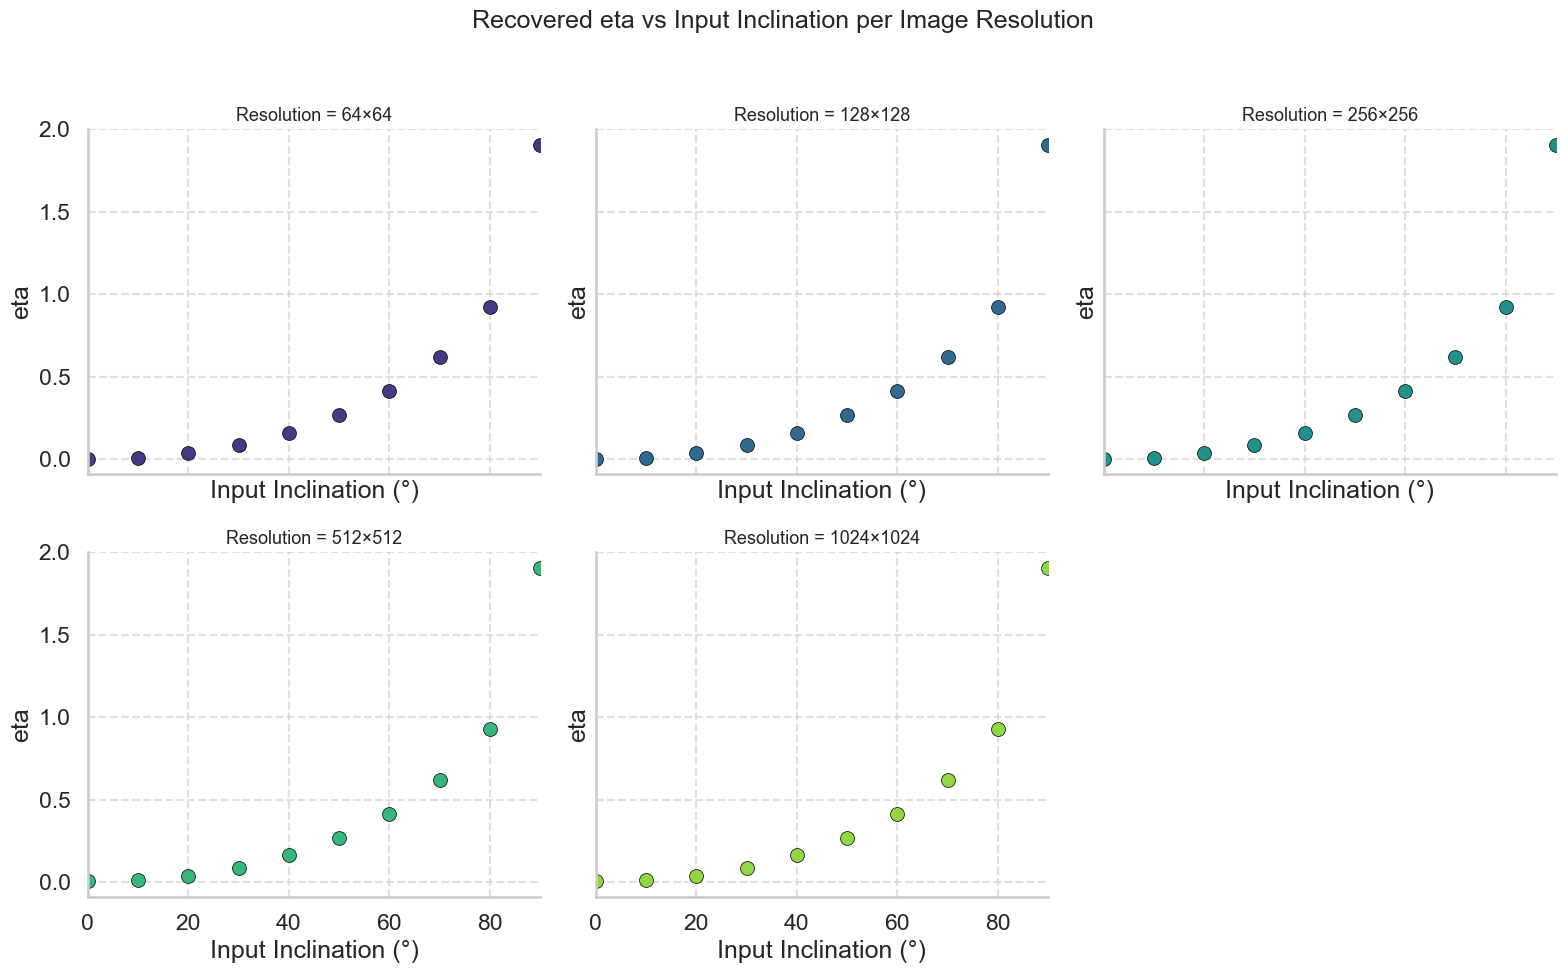

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert stored results to NumPy array if you haven't yet
records = np.array(records, dtype=float)
nb_vals, inc_in, inc_out = records[:, 0], records[:, 1], records[:, 2]


# Seaborn aesthetic
sns.set(style="whitegrid", context="talk")

# Unique resolution values (sorted ascending)
unique_nbins = sorted(set(nb_vals))

# Create subplots: one per resolution
ncols = 3
nrows = int(np.ceil(len(unique_nbins) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, nb in enumerate(unique_nbins):
    ax = axes[i]
    sel = nb_vals == nb
    
    ax.scatter(
        inc_in[sel], eta_out[sel],
        s=100, edgecolor='black', linewidth=0.5,
        color=sns.color_palette("viridis", len(unique_nbins))[i]
    )

    # Ideal reference line


    ax.set_title(f"Resolution = {int(nb)}×{int(nb)}", fontsize=13)
    ax.set_xlim(0, 90)

    ax.set_xlabel("Input Inclination (°)")
    
    ax.set_ylabel("eta")
    ax.grid(True, linestyle="--", alpha=0.6)

# Remove any unused subplots if grid > number of resolutions
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Recovered eta vs Input Inclination per Image Resolution", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
sns.despine()

plt.show()
